In [138]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [139]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [140]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [141]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [142]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [143]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [144]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [145]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [146]:
cm_train

array([[0.16323   ],
       [0.0930258 ],
       [0.02390559],
       ...,
       [0.02048   ],
       [0.044218  ],
       [0.04540032]])

In [147]:
index_train = define_index(cm, cm_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [148]:
len(cm[index_train])

3500

In [149]:
x_train

array([[0.276],
       [3.433],
       [2.041],
       ...,
       [0.039],
       [0.946],
       [4.916]])

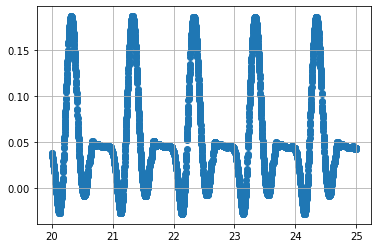

In [150]:
plt.scatter((x[index_train]), cm[index_train])
plt.grid()

In [151]:
len(index_train)

3500

In [152]:
x[index_train][:5]

array([[20.   ],
       [20.001],
       [20.006],
       [20.007],
       [20.008]])

In [153]:
cm[index_train][:5]

array([[0.038717],
       [0.038266],
       [0.03608 ],
       [0.035487],
       [0.034873]])

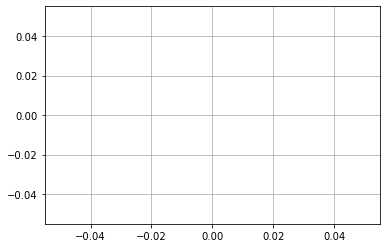

In [154]:
plt.scatter((x[index_test]), cm[index_test])
plt.grid()

In [155]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [156]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [157]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [158]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [159]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [160]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [161]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [162]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [163]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [164]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [165]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [166]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [167]:
x -=10

In [168]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [169]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=1)

In [63]:
len(x_test)

500

In [64]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [65]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_noflap_randomState1"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState1_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [94]:
model_directory = "D:\\TrainedModels\\20221226"

In [96]:
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState1CmPrediction.h5"
# model_directory = "D:\\TrainedModels\\20221226"
model = tf.keras.models.load_model(model_directory+"\\"+model_name)

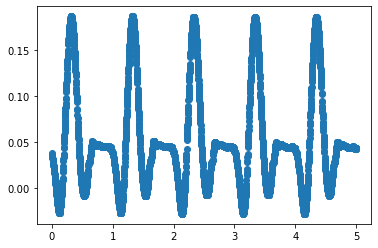

In [90]:
plt.scatter(x_train, cm_train)

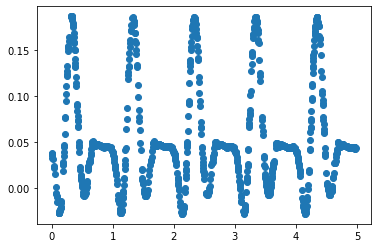

In [91]:
plt.scatter(x_val, cm_val)

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.1622 - rmse: 0.4026
Epoch 1: val_loss improved from inf to 0.12672, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 2s 110ms/step - loss: 0.1452 - rmse: 0.3809 - val_loss: 0.1267 - val_rmse: 0.3558 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1321 - rmse: 0.3634
Epoch 2: val_loss improved from 0.12672 to 0.10363, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.1155 - rmse: 0.3397 - val_loss: 0.1036 - val_rmse: 0.3218 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1076 - rmse: 0.3279
Epoch 3: val_loss improved from 0.10363 to 0.094

3/3 [==============================] - 0s 35ms/step - loss: 0.0737 - rmse: 0.2713 - val_loss: 0.0754 - val_rmse: 0.2744 - lr: 1.0000e-04
Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0739 - rmse: 0.2717
Epoch 21: val_loss improved from 0.07538 to 0.07406, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0739 - rmse: 0.2716 - val_loss: 0.0741 - val_rmse: 0.2720 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0706 - rmse: 0.2655
Epoch 22: val_loss improved from 0.07406 to 0.07252, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0712 - rmse: 0.2667 - val_loss: 0.0725 - val_rmse: 0.2691 - lr: 1.0000

Epoch 68/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0643 - rmse: 0.2535
Epoch 68: val_loss improved from 0.06651 to 0.06636, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0646 - rmse: 0.2539 - val_loss: 0.0664 - val_rmse: 0.2574 - lr: 1.0000e-04
Epoch 69/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0639 - rmse: 0.2526
Epoch 69: val_loss did not improve from 0.06636
3/3 [==============================] - 0s 21ms/step - loss: 0.0629 - rmse: 0.2506 - val_loss: 0.0667 - val_rmse: 0.2581 - lr: 1.0000e-04
Epoch 70/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2483
Epoch 70: val_loss did not improve from 0.06636
3/3 [==============================] - 0s 21ms/step - loss: 0.0614 - rmse: 0.2476 - val_loss: 0.0672 - val_rmse: 0.2590 - lr: 1.0000e-04
Epoch 71/100

3/3 [==============================] - 0s 43ms/step - loss: 0.0622 - rmse: 0.2491 - val_loss: 0.0651 - val_rmse: 0.2550 - lr: 1.0000e-04
Epoch 93/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0638 - rmse: 0.2524
Epoch 93: val_loss did not improve from 0.06515
3/3 [==============================] - 0s 21ms/step - loss: 0.0621 - rmse: 0.2490 - val_loss: 0.0658 - val_rmse: 0.2562 - lr: 1.0000e-04
Epoch 94/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2396
Epoch 94: val_loss did not improve from 0.06515
3/3 [==============================] - 0s 21ms/step - loss: 0.0590 - rmse: 0.2428 - val_loss: 0.0660 - val_rmse: 0.2566 - lr: 1.0000e-04
Epoch 95/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2485
Epoch 95: val_loss improved from 0.06515 to 0.06502, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [=======

1/3 [=========>....................] - ETA: 0s - loss: 0.0594 - rmse: 0.2435
Epoch 139: val_loss did not improve from 0.06180
3/3 [==============================] - 0s 21ms/step - loss: 0.0594 - rmse: 0.2436 - val_loss: 0.0619 - val_rmse: 0.2486 - lr: 1.0000e-04
Epoch 140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2348
Epoch 140: val_loss did not improve from 0.06180
3/3 [==============================] - 0s 21ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0621 - val_rmse: 0.2491 - lr: 1.0000e-04
Epoch 141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2413
Epoch 141: val_loss improved from 0.06180 to 0.06158, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0580 - rmse: 0.2407 - val_loss: 0.0616 - val_rmse: 0.2480 - lr: 1.0000e-04
Epoch 142/10000
1/3 [=

3/3 [==============================] - 0s 100ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0598 - val_rmse: 0.2443 - lr: 1.0000e-04
Epoch 164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2356
Epoch 164: val_loss did not improve from 0.05980
3/3 [==============================] - 0s 21ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0603 - val_rmse: 0.2453 - lr: 1.0000e-04
Epoch 165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2331
Epoch 165: val_loss did not improve from 0.05980
3/3 [==============================] - 0s 21ms/step - loss: 0.0559 - rmse: 0.2361 - val_loss: 0.0602 - val_rmse: 0.2452 - lr: 1.0000e-04
Epoch 166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 166: val_loss improved from 0.05980 to 0.05959, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [

3/3 [==============================] - 0s 51ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0588 - val_rmse: 0.2422 - lr: 1.0000e-04
Epoch 189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2321
Epoch 189: val_loss improved from 0.05876 to 0.05876, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0588 - val_rmse: 0.2422 - lr: 1.0000e-04
Epoch 190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2296
Epoch 190: val_loss did not improve from 0.05876
3/3 [==============================] - 0s 21ms/step - loss: 0.0533 - rmse: 0.2308 - val_loss: 0.0607 - val_rmse: 0.2462 - lr: 1.0000e-04
Epoch 191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2303
Epoch 191: val_loss improved from 0.05876 to 0.05836, s

Epoch 214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2319
Epoch 214: val_loss improved from 0.05749 to 0.05742, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0544 - rmse: 0.2331 - val_loss: 0.0574 - val_rmse: 0.2394 - lr: 1.0000e-04
Epoch 215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2195
Epoch 215: val_loss did not improve from 0.05742
3/3 [==============================] - 0s 21ms/step - loss: 0.0503 - rmse: 0.2239 - val_loss: 0.0583 - val_rmse: 0.2413 - lr: 1.0000e-04
Epoch 216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2325
Epoch 216: val_loss improved from 0.05742 to 0.05733, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_

1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2303
Epoch 265: val_loss improved from 0.05661 to 0.05661, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 266/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0440 - rmse: 0.2095
Epoch 266: val_loss did not improve from 0.05661
3/3 [==============================] - 0s 21ms/step - loss: 0.0509 - rmse: 0.2254 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 267: val_loss did not improve from 0.05661
3/3 [==============================] - 0s 21ms/step - loss: 0.0500 - rmse: 0.2234 - val_loss: 0.0573 - val_rmse: 0.2392 - lr: 1.0000e-04
Epoch 268/10000
1/3 [=

Epoch 292/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - rmse: 0.2149
Epoch 292: val_loss did not improve from 0.05651
3/3 [==============================] - 0s 21ms/step - loss: 0.0514 - rmse: 0.2265 - val_loss: 0.0572 - val_rmse: 0.2390 - lr: 1.0000e-04
Epoch 293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2233
Epoch 293: val_loss did not improve from 0.05651
3/3 [==============================] - 0s 21ms/step - loss: 0.0514 - rmse: 0.2266 - val_loss: 0.0566 - val_rmse: 0.2378 - lr: 1.0000e-04
Epoch 294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2214
Epoch 294: val_loss did not improve from 0.05651
3/3 [==============================] - 0s 21ms/step - loss: 0.0488 - rmse: 0.2206 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2313
Epoch 295: val_loss did not improve from 0.05651
3/3 [================

Epoch 348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2240
Epoch 348: val_loss did not improve from 0.05637
3/3 [==============================] - 0s 22ms/step - loss: 0.0502 - rmse: 0.2238 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2224
Epoch 349: val_loss did not improve from 0.05637
3/3 [==============================] - 0s 21ms/step - loss: 0.0503 - rmse: 0.2240 - val_loss: 0.0565 - val_rmse: 0.2375 - lr: 1.0000e-04
Epoch 350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2320
Epoch 350: val_loss did not improve from 0.05637
3/3 [==============================] - 0s 21ms/step - loss: 0.0526 - rmse: 0.2292 - val_loss: 0.0565 - val_rmse: 0.2375 - lr: 1.0000e-04
Epoch 351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - rmse: 0.2210
Epoch 351: val_loss did not improve from 0.05637
3/3 [================

Epoch 376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2269
Epoch 376: val_loss did not improve from 0.05633
3/3 [==============================] - 0s 21ms/step - loss: 0.0515 - rmse: 0.2267 - val_loss: 0.0565 - val_rmse: 0.2374 - lr: 1.0000e-04
Epoch 377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2356
Epoch 377: val_loss did not improve from 0.05633
3/3 [==============================] - 0s 21ms/step - loss: 0.0511 - rmse: 0.2258 - val_loss: 0.0564 - val_rmse: 0.2372 - lr: 1.0000e-04
Epoch 378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2247
Epoch 378: val_loss did not improve from 0.05633
3/3 [==============================] - 0s 22ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0569 - val_rmse: 0.2383 - lr: 1.0000e-04
Epoch 379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - rmse: 0.2209
Epoch 379: val_loss did not improve from 0.05633
3/3 [================

Epoch 404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 404: val_loss did not improve from 0.05617
3/3 [==============================] - 0s 20ms/step - loss: 0.0499 - rmse: 0.2231 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 405: val_loss did not improve from 0.05617
3/3 [==============================] - 0s 21ms/step - loss: 0.0514 - rmse: 0.2264 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0462 - rmse: 0.2148
Epoch 406: val_loss did not improve from 0.05617
3/3 [==============================] - 0s 21ms/step - loss: 0.0509 - rmse: 0.2253 - val_loss: 0.0563 - val_rmse: 0.2370 - lr: 1.0000e-04
Epoch 407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0509 - rmse: 0.2255
Epoch 407: val_loss did not improve from 0.05617
3/3 [================

Epoch 432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2226
Epoch 432: val_loss did not improve from 0.05607
3/3 [==============================] - 0s 21ms/step - loss: 0.0505 - rmse: 0.2246 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 433: val_loss did not improve from 0.05607
3/3 [==============================] - 0s 20ms/step - loss: 0.0505 - rmse: 0.2245 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2224
Epoch 434: val_loss did not improve from 0.05607
3/3 [==============================] - 0s 21ms/step - loss: 0.0503 - rmse: 0.2241 - val_loss: 0.0563 - val_rmse: 0.2370 - lr: 1.0000e-04
Epoch 435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2228
Epoch 435: val_loss did not improve from 0.05607
3/3 [================

Epoch 460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2132
Epoch 460: val_loss did not improve from 0.05583
3/3 [==============================] - 0s 22ms/step - loss: 0.0511 - rmse: 0.2259 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2240
Epoch 461: val_loss did not improve from 0.05583
3/3 [==============================] - 0s 21ms/step - loss: 0.0505 - rmse: 0.2244 - val_loss: 0.0565 - val_rmse: 0.2374 - lr: 1.0000e-04
Epoch 462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2279
Epoch 462: val_loss did not improve from 0.05583
3/3 [==============================] - 0s 21ms/step - loss: 0.0522 - rmse: 0.2282 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2218
Epoch 463: val_loss did not improve from 0.05583
3/3 [================

Epoch 488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 488: val_loss did not improve from 0.05562
3/3 [==============================] - 0s 21ms/step - loss: 0.0516 - rmse: 0.2269 - val_loss: 0.0560 - val_rmse: 0.2364 - lr: 1.0000e-04
Epoch 489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2218
Epoch 489: val_loss did not improve from 0.05562
3/3 [==============================] - 0s 21ms/step - loss: 0.0499 - rmse: 0.2232 - val_loss: 0.0565 - val_rmse: 0.2375 - lr: 1.0000e-04
Epoch 490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0543 - rmse: 0.2327
Epoch 490: val_loss did not improve from 0.05562
3/3 [==============================] - 0s 21ms/step - loss: 0.0502 - rmse: 0.2239 - val_loss: 0.0558 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2220
Epoch 491: val_loss improved from 0.05562 to 0.05560, saving model to 

Epoch 514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2297
Epoch 514: val_loss improved from 0.05542 to 0.05540, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0554 - val_rmse: 0.2352 - lr: 1.0000e-04
Epoch 515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0502 - rmse: 0.2239
Epoch 515: val_loss did not improve from 0.05540
3/3 [==============================] - 0s 21ms/step - loss: 0.0498 - rmse: 0.2231 - val_loss: 0.0560 - val_rmse: 0.2364 - lr: 1.0000e-04
Epoch 516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2259
Epoch 516: val_loss did not improve from 0.05540
3/3 [==============================] - 0s 21ms/step - loss: 0.0492 - rmse: 0.2217 - val_loss: 0.0556 - val_rmse: 0.2357 - lr: 1.0000e-04
Epoch 

Epoch 541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2242
Epoch 541: val_loss did not improve from 0.05517
3/3 [==============================] - 0s 21ms/step - loss: 0.0490 - rmse: 0.2212 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2267
Epoch 542: val_loss improved from 0.05517 to 0.05507, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0518 - rmse: 0.2275 - val_loss: 0.0551 - val_rmse: 0.2345 - lr: 1.0000e-04
Epoch 543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2180
Epoch 543: val_loss did not improve from 0.05507
3/3 [==============================] - 0s 21ms/step - loss: 0.0478 - rmse: 0.2184 - val_loss: 0.0562 - val_rmse: 0.2370 - lr: 1.0000e-04
Epoch 

Epoch 567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0471 - rmse: 0.2169
Epoch 567: val_loss did not improve from 0.05480
3/3 [==============================] - 0s 21ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0552 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2260
Epoch 568: val_loss did not improve from 0.05480
3/3 [==============================] - 0s 22ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0575 - val_rmse: 0.2397 - lr: 1.0000e-04
Epoch 569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2223
Epoch 569: val_loss did not improve from 0.05480
3/3 [==============================] - 0s 21ms/step - loss: 0.0513 - rmse: 0.2264 - val_loss: 0.0549 - val_rmse: 0.2342 - lr: 1.0000e-04
Epoch 570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0447 - rmse: 0.2111
Epoch 570: val_loss did not improve from 0.05480
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2073
Epoch 621: val_loss did not improve from 0.05380
3/3 [==============================] - 0s 21ms/step - loss: 0.0480 - rmse: 0.2189 - val_loss: 0.0539 - val_rmse: 0.2321 - lr: 1.0000e-04
Epoch 622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2173
Epoch 622: val_loss did not improve from 0.05380
3/3 [==============================] - 0s 21ms/step - loss: 0.0469 - rmse: 0.2164 - val_loss: 0.0549 - val_rmse: 0.2342 - lr: 1.0000e-04
Epoch 623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2257
Epoch 623: val_loss improved from 0.05380 to 0.05372, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0495 - rmse: 0.2223 - val_loss: 0.0537 - val_rmse: 0.2316 - lr: 1.0000e-04
Epoch 624/10000
1/3 [=

Epoch 648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0451 - rmse: 0.2121
Epoch 648: val_loss did not improve from 0.05317
3/3 [==============================] - 0s 21ms/step - loss: 0.0483 - rmse: 0.2196 - val_loss: 0.0533 - val_rmse: 0.2308 - lr: 1.0000e-04
Epoch 649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0450 - rmse: 0.2119
Epoch 649: val_loss did not improve from 0.05317
3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2160 - val_loss: 0.0537 - val_rmse: 0.2315 - lr: 1.0000e-04
Epoch 650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 650: val_loss did not improve from 0.05317
3/3 [==============================] - 0s 21ms/step - loss: 0.0469 - rmse: 0.2163 - val_loss: 0.0534 - val_rmse: 0.2310 - lr: 1.0000e-04
Epoch 651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0455 - rmse: 0.2130
Epoch 651: val_loss did not improve from 0.05317
3/3 [================

Epoch 700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0454 - rmse: 0.2128
Epoch 700: val_loss did not improve from 0.05171
3/3 [==============================] - 0s 21ms/step - loss: 0.0445 - rmse: 0.2107 - val_loss: 0.0524 - val_rmse: 0.2288 - lr: 1.0000e-04
Epoch 701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2074
Epoch 701: val_loss did not improve from 0.05171
3/3 [==============================] - 0s 21ms/step - loss: 0.0458 - rmse: 0.2137 - val_loss: 0.0519 - val_rmse: 0.2275 - lr: 1.0000e-04
Epoch 702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0459 - rmse: 0.2141
Epoch 702: val_loss did not improve from 0.05171
3/3 [==============================] - 0s 21ms/step - loss: 0.0449 - rmse: 0.2117 - val_loss: 0.0519 - val_rmse: 0.2276 - lr: 1.0000e-04
Epoch 703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2196
Epoch 703: val_loss did not improve from 0.05171
3/3 [================

3/3 [==============================] - 0s 49ms/step - loss: 0.0442 - rmse: 0.2100 - val_loss: 0.0505 - val_rmse: 0.2245 - lr: 1.0000e-04
Epoch 726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2125
Epoch 726: val_loss did not improve from 0.05046
3/3 [==============================] - 0s 21ms/step - loss: 0.0441 - rmse: 0.2098 - val_loss: 0.0511 - val_rmse: 0.2258 - lr: 1.0000e-04
Epoch 727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2133
Epoch 727: val_loss did not improve from 0.05046
3/3 [==============================] - 0s 21ms/step - loss: 0.0456 - rmse: 0.2133 - val_loss: 0.0505 - val_rmse: 0.2246 - lr: 1.0000e-04
Epoch 728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0440 - rmse: 0.2097
Epoch 728: val_loss did not improve from 0.05046
3/3 [==============================] - 0s 21ms/step - loss: 0.0444 - rmse: 0.2105 - val_loss: 0.0505 - val_rmse: 0.2246 - lr: 1.0000e-04
Epoch 729/10000
1/3 [=====

Epoch 751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2009
Epoch 751: val_loss did not improve from 0.04954
3/3 [==============================] - 0s 21ms/step - loss: 0.0410 - rmse: 0.2023 - val_loss: 0.0496 - val_rmse: 0.2224 - lr: 1.0000e-04
Epoch 752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2128
Epoch 752: val_loss did not improve from 0.04954
3/3 [==============================] - 0s 21ms/step - loss: 0.0436 - rmse: 0.2085 - val_loss: 0.0510 - val_rmse: 0.2257 - lr: 1.0000e-04
Epoch 753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0411 - rmse: 0.2026
Epoch 753: val_loss improved from 0.04954 to 0.04948, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0422 - rmse: 0.2053 - val_loss: 0.0495 - val_rmse: 0.2222 - lr: 1.0000e-04
Epoch 

Epoch 777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0470 - rmse: 0.2165
Epoch 777: val_loss did not improve from 0.04815
3/3 [==============================] - 0s 21ms/step - loss: 0.0426 - rmse: 0.2062 - val_loss: 0.0491 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 778/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1962
Epoch 778: val_loss did not improve from 0.04815
3/3 [==============================] - 0s 21ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0485 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0439 - rmse: 0.2093
Epoch 779: val_loss did not improve from 0.04815
3/3 [==============================] - 0s 21ms/step - loss: 0.0418 - rmse: 0.2041 - val_loss: 0.0492 - val_rmse: 0.2217 - lr: 1.0000e-04
Epoch 780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2005
Epoch 780: val_loss improved from 0.04815 to 0.04764, saving model to 

Epoch 804/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2034
Epoch 804: val_loss improved from 0.04675 to 0.04655, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0414 - rmse: 0.2033 - val_loss: 0.0465 - val_rmse: 0.2156 - lr: 1.0000e-04
Epoch 805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1971
Epoch 805: val_loss did not improve from 0.04655
3/3 [==============================] - 0s 21ms/step - loss: 0.0409 - rmse: 0.2020 - val_loss: 0.0479 - val_rmse: 0.2188 - lr: 1.0000e-04
Epoch 806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1962
Epoch 806: val_loss did not improve from 0.04655
3/3 [==============================] - 0s 21ms/step - loss: 0.0402 - rmse: 0.2002 - val_loss: 0.0471 - val_rmse: 0.2168 - lr: 1.0000e-04
Epoch 

3/3 [==============================] - 0s 47ms/step - loss: 0.0383 - rmse: 0.1956 - val_loss: 0.0456 - val_rmse: 0.2134 - lr: 1.0000e-04
Epoch 829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0400 - rmse: 0.1998
Epoch 829: val_loss did not improve from 0.04562
3/3 [==============================] - 0s 21ms/step - loss: 0.0383 - rmse: 0.1955 - val_loss: 0.0473 - val_rmse: 0.2173 - lr: 1.0000e-04
Epoch 830/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0458 - rmse: 0.2138
Epoch 830: val_loss improved from 0.04562 to 0.04556, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0456 - val_rmse: 0.2132 - lr: 1.0000e-04
Epoch 831/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 831: val_loss did not improve from 0.04556
3/3 [=

3/3 [==============================] - 0s 50ms/step - loss: 0.0379 - rmse: 0.1945 - val_loss: 0.0447 - val_rmse: 0.2111 - lr: 1.0000e-04
Epoch 854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - rmse: 0.1904
Epoch 854: val_loss did not improve from 0.04466
3/3 [==============================] - 0s 21ms/step - loss: 0.0366 - rmse: 0.1910 - val_loss: 0.0447 - val_rmse: 0.2112 - lr: 1.0000e-04
Epoch 855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1911
Epoch 855: val_loss improved from 0.04466 to 0.04431, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0396 - rmse: 0.1987 - val_loss: 0.0443 - val_rmse: 0.2103 - lr: 1.0000e-04
Epoch 856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1942
Epoch 856: val_loss did not improve from 0.04431
3/3 [=

3/3 [==============================] - 0s 21ms/step - loss: 0.0378 - rmse: 0.1941 - val_loss: 0.0436 - val_rmse: 0.2086 - lr: 1.0000e-04
Epoch 880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1879
Epoch 880: val_loss did not improve from 0.04338
3/3 [==============================] - 0s 21ms/step - loss: 0.0355 - rmse: 0.1881 - val_loss: 0.0436 - val_rmse: 0.2086 - lr: 1.0000e-04
Epoch 881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0352 - rmse: 0.1873
Epoch 881: val_loss did not improve from 0.04338
3/3 [==============================] - 0s 21ms/step - loss: 0.0371 - rmse: 0.1925 - val_loss: 0.0435 - val_rmse: 0.2083 - lr: 1.0000e-04
Epoch 882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1842
Epoch 882: val_loss did not improve from 0.04338
3/3 [==============================] - 0s 22ms/step - loss: 0.0348 - rmse: 0.1864 - val_loss: 0.0440 - val_rmse: 0.2095 - lr: 1.0000e-04
Epoch 883/10000
1/3 [=====

3/3 [==============================] - 0s 46ms/step - loss: 0.0367 - rmse: 0.1913 - val_loss: 0.0422 - val_rmse: 0.2052 - lr: 1.0000e-04
Epoch 906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1742
Epoch 906: val_loss did not improve from 0.04220
3/3 [==============================] - 0s 21ms/step - loss: 0.0354 - rmse: 0.1879 - val_loss: 0.0438 - val_rmse: 0.2092 - lr: 1.0000e-04
Epoch 907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1884
Epoch 907: val_loss did not improve from 0.04220
3/3 [==============================] - 0s 21ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0423 - val_rmse: 0.2056 - lr: 1.0000e-04
Epoch 908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1940
Epoch 908: val_loss did not improve from 0.04220
3/3 [==============================] - 0s 21ms/step - loss: 0.0358 - rmse: 0.1891 - val_loss: 0.0431 - val_rmse: 0.2074 - lr: 1.0000e-04
Epoch 909/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1788
Epoch 958: val_loss did not improve from 0.04073
3/3 [==============================] - 0s 21ms/step - loss: 0.0330 - rmse: 0.1813 - val_loss: 0.0416 - val_rmse: 0.2037 - lr: 1.0000e-04
Epoch 959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0342 - rmse: 0.1848
Epoch 959: val_loss improved from 0.04073 to 0.04047, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0344 - rmse: 0.1853 - val_loss: 0.0405 - val_rmse: 0.2010 - lr: 1.0000e-04
Epoch 960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1788
Epoch 960: val_loss did not improve from 0.04047
3/3 [==============================] - 0s 21ms/step - loss: 0.0339 - rmse: 0.1839 - val_loss: 0.0416 - val_rmse: 0.2037 - lr: 1.0000e-04
Epoch 961/10000
1/3 [=

Epoch 1013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1858
Epoch 1013: val_loss did not improve from 0.03956
3/3 [==============================] - 0s 21ms/step - loss: 0.0335 - rmse: 0.1827 - val_loss: 0.0407 - val_rmse: 0.2015 - lr: 1.0000e-04
Epoch 1014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 1014: val_loss did not improve from 0.03956
3/3 [==============================] - 0s 21ms/step - loss: 0.0329 - rmse: 0.1810 - val_loss: 0.0401 - val_rmse: 0.2001 - lr: 1.0000e-04
Epoch 1015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0327 - rmse: 0.1806
Epoch 1015: val_loss did not improve from 0.03956
3/3 [==============================] - 0s 20ms/step - loss: 0.0335 - rmse: 0.1829 - val_loss: 0.0409 - val_rmse: 0.2020 - lr: 1.0000e-04
Epoch 1016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1808
Epoch 1016: val_loss did not improve from 0.03956
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0391 - val_rmse: 0.1977 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0320 - rmse: 0.1786
Epoch 1040: val_loss did not improve from 0.03899
3/3 [==============================] - 0s 20ms/step - loss: 0.0314 - rmse: 0.1770 - val_loss: 0.0397 - val_rmse: 0.1992 - lr: 1.0000e-04
Epoch 1041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0309 - rmse: 0.1757
Epoch 1041: val_loss did not improve from 0.03899
3/3 [==============================] - 0s 21ms/step - loss: 0.0321 - rmse: 0.1788 - val_loss: 0.0400 - val_rmse: 0.1998 - lr: 1.0000e-04
Epoch 1042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1801
Epoch 1042: val_loss did not improve from 0.03899
3/3 [==============================] - 0s 21ms/step - loss: 0.0327 - rmse: 0.1807 - val_loss: 0.0394 - val_rmse: 0.1982 - lr: 1.0000e-04
Epoch 1043/10000
1/3

Epoch 1067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1777
Epoch 1067: val_loss did not improve from 0.03857
3/3 [==============================] - 0s 21ms/step - loss: 0.0293 - rmse: 0.1711 - val_loss: 0.0409 - val_rmse: 0.2021 - lr: 1.0000e-04
Epoch 1068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1809
Epoch 1068: val_loss did not improve from 0.03857
3/3 [==============================] - 0s 21ms/step - loss: 0.0332 - rmse: 0.1821 - val_loss: 0.0386 - val_rmse: 0.1963 - lr: 1.0000e-04
Epoch 1069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1793
Epoch 1069: val_loss did not improve from 0.03857
3/3 [==============================] - 0s 21ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0395 - val_rmse: 0.1984 - lr: 1.0000e-04
Epoch 1070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1793
Epoch 1070: val_loss did not improve from 0.03857
3/3 [========

3/3 [==============================] - 0s 52ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 1094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1606
Epoch 1094: val_loss did not improve from 0.03779
3/3 [==============================] - 0s 21ms/step - loss: 0.0303 - rmse: 0.1739 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 1095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0298 - rmse: 0.1725
Epoch 1095: val_loss did not improve from 0.03779
3/3 [==============================] - 0s 22ms/step - loss: 0.0300 - rmse: 0.1730 - val_loss: 0.0385 - val_rmse: 0.1961 - lr: 1.0000e-04
Epoch 1096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1774
Epoch 1096: val_loss did not improve from 0.03779
3/3 [==============================] - 0s 21ms/step - loss: 0.0312 - rmse: 0.1765 - val_loss: 0.0379 - val_rmse: 0.1946 - lr: 1.0000e-04
Epoch 1097/10000
1/3

Epoch 1122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - rmse: 0.1897
Epoch 1122: val_loss improved from 0.03772 to 0.03741, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0325 - rmse: 0.1801 - val_loss: 0.0374 - val_rmse: 0.1932 - lr: 1.0000e-04
Epoch 1123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1693
Epoch 1123: val_loss did not improve from 0.03741
3/3 [==============================] - 0s 21ms/step - loss: 0.0307 - rmse: 0.1750 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 1124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1684
Epoch 1124: val_loss did not improve from 0.03741
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1722 - val_loss: 0.0376 - val_rmse: 0.1937 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0300 - rmse: 0.1729 - val_loss: 0.0373 - val_rmse: 0.1931 - lr: 1.0000e-04
Epoch 1150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1741
Epoch 1150: val_loss did not improve from 0.03729
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1721 - val_loss: 0.0375 - val_rmse: 0.1936 - lr: 1.0000e-04
Epoch 1151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0309 - rmse: 0.1756
Epoch 1151: val_loss did not improve from 0.03729
3/3 [==============================] - 0s 21ms/step - loss: 0.0295 - rmse: 0.1715 - val_loss: 0.0373 - val_rmse: 0.1930 - lr: 1.0000e-04
Epoch 1152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1785
Epoch 1152: val_loss did not improve from 0.03729
3/3 [==============================] - 0s 22ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0389 - val_rmse: 0.1969 - lr: 1.0000e-04
Epoch 1153/10000
1/3

Epoch 1178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1776
Epoch 1178: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 21ms/step - loss: 0.0309 - rmse: 0.1757 - val_loss: 0.0372 - val_rmse: 0.1926 - lr: 1.0000e-04
Epoch 1179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1748
Epoch 1179: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 22ms/step - loss: 0.0307 - rmse: 0.1749 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000e-04
Epoch 1180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1716
Epoch 1180: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1723 - val_loss: 0.0369 - val_rmse: 0.1919 - lr: 1.0000e-04
Epoch 1181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1785
Epoch 1181: val_loss improved from 0.03678 to 0.03674, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1733 - val_loss: 0.0370 - val_rmse: 0.1923 - lr: 1.0000e-04
Epoch 1205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1709
Epoch 1205: val_loss did not improve from 0.03631
3/3 [==============================] - 0s 21ms/step - loss: 0.0300 - rmse: 0.1729 - val_loss: 0.0367 - val_rmse: 0.1913 - lr: 1.0000e-04
Epoch 1206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0276 - rmse: 0.1660
Epoch 1206: val_loss did not improve from 0.03631
3/3 [==============================] - 0s 20ms/step - loss: 0.0292 - rmse: 0.1707 - val_loss: 0.0368 - val_rmse: 0.1916 - lr: 1.0000e-04
Epoch 1207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1712
Epoch 1207: val_loss did not improve from 0.03631
3/3 [==============================] - 0s 20ms/step - loss: 0.0296 - rmse: 0.1717 - val_loss: 0.0379 - val_rmse: 0.1944 - lr: 1.0000e-04
Epoch 1208/10000
1/3

Epoch 1260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0301 - rmse: 0.1732
Epoch 1260: val_loss did not improve from 0.03556
3/3 [==============================] - 0s 20ms/step - loss: 0.0305 - rmse: 0.1745 - val_loss: 0.0360 - val_rmse: 0.1895 - lr: 1.0000e-04
Epoch 1261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1719
Epoch 1261: val_loss did not improve from 0.03556
3/3 [==============================] - 0s 21ms/step - loss: 0.0291 - rmse: 0.1704 - val_loss: 0.0359 - val_rmse: 0.1893 - lr: 1.0000e-04
Epoch 1262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1580
Epoch 1262: val_loss did not improve from 0.03556
3/3 [==============================] - 0s 21ms/step - loss: 0.0289 - rmse: 0.1698 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 1263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1581
Epoch 1263: val_loss did not improve from 0.03556
3/3 [========

Epoch 1286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1747
Epoch 1286: val_loss did not improve from 0.03512
3/3 [==============================] - 0s 22ms/step - loss: 0.0299 - rmse: 0.1728 - val_loss: 0.0354 - val_rmse: 0.1879 - lr: 1.0000e-04
Epoch 1287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1651
Epoch 1287: val_loss did not improve from 0.03512
3/3 [==============================] - 0s 21ms/step - loss: 0.0276 - rmse: 0.1659 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 1288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1728
Epoch 1288: val_loss did not improve from 0.03512
3/3 [==============================] - 0s 21ms/step - loss: 0.0291 - rmse: 0.1704 - val_loss: 0.0370 - val_rmse: 0.1923 - lr: 1.0000e-04
Epoch 1289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1707
Epoch 1289: val_loss did not improve from 0.03512
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0282 - rmse: 0.1676 - val_loss: 0.0351 - val_rmse: 0.1873 - lr: 1.0000e-04
Epoch 1314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1688
Epoch 1314: val_loss did not improve from 0.03486
3/3 [==============================] - 0s 21ms/step - loss: 0.0280 - rmse: 0.1671 - val_loss: 0.0361 - val_rmse: 0.1898 - lr: 1.0000e-04
Epoch 1315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1315: val_loss improved from 0.03486 to 0.03478, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0287 - rmse: 0.1691 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1689
Epoch 1316: val_loss did not improve from 0.03478


Epoch 1342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1716
Epoch 1342: val_loss did not improve from 0.03473
3/3 [==============================] - 0s 21ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1632
Epoch 1343: val_loss improved from 0.03473 to 0.03445, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 39ms/step - loss: 0.0278 - rmse: 0.1666 - val_loss: 0.0344 - val_rmse: 0.1854 - lr: 1.0000e-04
Epoch 1344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1663
Epoch 1344: val_loss did not improve from 0.03445
3/3 [==============================] - 0s 21ms/step - loss: 0.0268 - rmse: 0.1634 - val_loss: 0.0349 - val_rmse: 0.1866 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1709
Epoch 1370: val_loss improved from 0.03420 to 0.03407, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0287 - rmse: 0.1691 - val_loss: 0.0341 - val_rmse: 0.1844 - lr: 1.0000e-04
Epoch 1371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1607
Epoch 1371: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 21ms/step - loss: 0.0256 - rmse: 0.1598 - val_loss: 0.0363 - val_rmse: 0.1904 - lr: 1.0000e-04
Epoch 1372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1720
Epoch 1372: val_loss did not improve from 0.03407
3/3 [==============================] - 0s 20ms/step - loss: 0.0290 - rmse: 0.1701 - val_loss: 0.0343 - val_rmse: 0.1851 - lr: 1.0000e-04
Epoch 1373/10000


Epoch 1397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1654
Epoch 1397: val_loss did not improve from 0.03385
3/3 [==============================] - 0s 21ms/step - loss: 0.0275 - rmse: 0.1658 - val_loss: 0.0344 - val_rmse: 0.1854 - lr: 1.0000e-04
Epoch 1398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1578
Epoch 1398: val_loss did not improve from 0.03385
3/3 [==============================] - 0s 21ms/step - loss: 0.0247 - rmse: 0.1569 - val_loss: 0.0351 - val_rmse: 0.1871 - lr: 1.0000e-04
Epoch 1399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0314 - rmse: 0.1770
Epoch 1399: val_loss did not improve from 0.03385
3/3 [==============================] - 0s 20ms/step - loss: 0.0294 - rmse: 0.1713 - val_loss: 0.0347 - val_rmse: 0.1862 - lr: 1.0000e-04
Epoch 1400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1664
Epoch 1400: val_loss improved from 0.03385 to 0.03368, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0273 - rmse: 0.1649 - val_loss: 0.0336 - val_rmse: 0.1831 - lr: 1.0000e-04
Epoch 1425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1651
Epoch 1425: val_loss did not improve from 0.03350
3/3 [==============================] - 0s 21ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0340 - val_rmse: 0.1841 - lr: 1.0000e-04
Epoch 1426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1716
Epoch 1426: val_loss did not improve from 0.03350
3/3 [==============================] - 0s 21ms/step - loss: 0.0284 - rmse: 0.1683 - val_loss: 0.0338 - val_rmse: 0.1835 - lr: 1.0000e-04
Epoch 1427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1633
Epoch 1427: val_loss did not improve from 0.03350
3/3 [==============================] - 0s 21ms/step - loss: 0.0268 - rmse: 0.1634 - val_loss: 0.0335 - val_rmse: 0.1829 - lr: 1.0000e-04
Epoch 1428/10000
1/3

Epoch 1452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1621
Epoch 1452: val_loss did not improve from 0.03321
3/3 [==============================] - 0s 22ms/step - loss: 0.0272 - rmse: 0.1646 - val_loss: 0.0335 - val_rmse: 0.1828 - lr: 1.0000e-04
Epoch 1453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1626
Epoch 1453: val_loss did not improve from 0.03321
3/3 [==============================] - 0s 21ms/step - loss: 0.0274 - rmse: 0.1654 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0249 - rmse: 0.1576
Epoch 1454: val_loss did not improve from 0.03321
3/3 [==============================] - 0s 21ms/step - loss: 0.0268 - rmse: 0.1636 - val_loss: 0.0340 - val_rmse: 0.1842 - lr: 1.0000e-04
Epoch 1455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1619
Epoch 1455: val_loss did not improve from 0.03321
3/3 [========

Epoch 1479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0237 - rmse: 0.1536
Epoch 1479: val_loss did not improve from 0.03275
3/3 [==============================] - 0s 22ms/step - loss: 0.0249 - rmse: 0.1576 - val_loss: 0.0333 - val_rmse: 0.1824 - lr: 1.0000e-04
Epoch 1480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1512
Epoch 1480: val_loss improved from 0.03275 to 0.03275, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0259 - rmse: 0.1606 - val_loss: 0.0327 - val_rmse: 0.1808 - lr: 1.0000e-04
Epoch 1481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - rmse: 0.1641
Epoch 1481: val_loss did not improve from 0.03275
3/3 [==============================] - 0s 21ms/step - loss: 0.0254 - rmse: 0.1590 - val_loss: 0.0335 - val_rmse: 0.1828 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0270 - rmse: 0.1642 - val_loss: 0.0329 - val_rmse: 0.1811 - lr: 1.0000e-04
Epoch 1507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1625
Epoch 1507: val_loss did not improve from 0.03250
3/3 [==============================] - 0s 21ms/step - loss: 0.0256 - rmse: 0.1599 - val_loss: 0.0329 - val_rmse: 0.1813 - lr: 1.0000e-04
Epoch 1508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1594
Epoch 1508: val_loss did not improve from 0.03250
3/3 [==============================] - 0s 22ms/step - loss: 0.0262 - rmse: 0.1615 - val_loss: 0.0360 - val_rmse: 0.1896 - lr: 1.0000e-04
Epoch 1509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1682
Epoch 1509: val_loss improved from 0.03250 to 0.03235, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5


Epoch 1535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 1535: val_loss did not improve from 0.03219
3/3 [==============================] - 0s 21ms/step - loss: 0.0243 - rmse: 0.1557 - val_loss: 0.0330 - val_rmse: 0.1813 - lr: 1.0000e-04
Epoch 1536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1672
Epoch 1536: val_loss did not improve from 0.03219
3/3 [==============================] - 0s 21ms/step - loss: 0.0262 - rmse: 0.1616 - val_loss: 0.0324 - val_rmse: 0.1797 - lr: 1.0000e-04
Epoch 1537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1532
Epoch 1537: val_loss did not improve from 0.03219
3/3 [==============================] - 0s 21ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0325 - val_rmse: 0.1800 - lr: 1.0000e-04
Epoch 1538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1544
Epoch 1538: val_loss improved from 0.03219 to 0.03214, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0269 - rmse: 0.1638 - val_loss: 0.0320 - val_rmse: 0.1788 - lr: 1.0000e-04
Epoch 1562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1515
Epoch 1562: val_loss did not improve from 0.03184
3/3 [==============================] - 0s 21ms/step - loss: 0.0265 - rmse: 0.1627 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 1.0000e-04
Epoch 1563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1532
Epoch 1563: val_loss did not improve from 0.03184
3/3 [==============================] - 0s 21ms/step - loss: 0.0244 - rmse: 0.1561 - val_loss: 0.0333 - val_rmse: 0.1822 - lr: 1.0000e-04
Epoch 1564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1564: val_loss did not improve from 0.03184
3/3 [==============================] - 0s 22ms/step - loss: 0.0259 - rmse: 0.1606 - val_loss: 0.0323 - val_rmse: 0.1796 - lr: 1.0000e-04
Epoch 1565/10000
1/3

Epoch 1617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0243 - rmse: 0.1556
Epoch 1617: val_loss did not improve from 0.03138
3/3 [==============================] - 0s 21ms/step - loss: 0.0251 - rmse: 0.1583 - val_loss: 0.0314 - val_rmse: 0.1770 - lr: 1.0000e-04
Epoch 1618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 1618: val_loss did not improve from 0.03138
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1549 - val_loss: 0.0317 - val_rmse: 0.1780 - lr: 1.0000e-04
Epoch 1619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0237 - rmse: 0.1538
Epoch 1619: val_loss improved from 0.03138 to 0.03106, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0247 - rmse: 0.1569 - val_loss: 0.0311 - val_rmse: 0.1760 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1612
Epoch 1645: val_loss did not improve from 0.03091
3/3 [==============================] - 0s 21ms/step - loss: 0.0251 - rmse: 0.1582 - val_loss: 0.0330 - val_rmse: 0.1814 - lr: 1.0000e-04
Epoch 1646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1633
Epoch 1646: val_loss did not improve from 0.03091
3/3 [==============================] - 0s 21ms/step - loss: 0.0278 - rmse: 0.1665 - val_loss: 0.0311 - val_rmse: 0.1762 - lr: 1.0000e-04
Epoch 1647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1502
Epoch 1647: val_loss did not improve from 0.03091
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1541 - val_loss: 0.0317 - val_rmse: 0.1779 - lr: 1.0000e-04
Epoch 1648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1543
Epoch 1648: val_loss did not improve from 0.03091
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1424
Epoch 1701: val_loss did not improve from 0.03043
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1540 - val_loss: 0.0309 - val_rmse: 0.1756 - lr: 1.0000e-04
Epoch 1702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0283 - rmse: 0.1681
Epoch 1702: val_loss did not improve from 0.03043
3/3 [==============================] - 0s 21ms/step - loss: 0.0258 - rmse: 0.1603 - val_loss: 0.0306 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 1703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1519
Epoch 1703: val_loss did not improve from 0.03043
3/3 [==============================] - 0s 20ms/step - loss: 0.0237 - rmse: 0.1539 - val_loss: 0.0317 - val_rmse: 0.1777 - lr: 1.0000e-04
Epoch 1704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 1704: val_loss did not improve from 0.03043
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0276 - rmse: 0.1659
Epoch 1757: val_loss did not improve from 0.02982
3/3 [==============================] - 0s 21ms/step - loss: 0.0246 - rmse: 0.1565 - val_loss: 0.0305 - val_rmse: 0.1744 - lr: 1.0000e-04
Epoch 1758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1407
Epoch 1758: val_loss did not improve from 0.02982
3/3 [==============================] - 0s 21ms/step - loss: 0.0224 - rmse: 0.1496 - val_loss: 0.0308 - val_rmse: 0.1753 - lr: 1.0000e-04
Epoch 1759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1499
Epoch 1759: val_loss did not improve from 0.02982
3/3 [==============================] - 0s 21ms/step - loss: 0.0254 - rmse: 0.1592 - val_loss: 0.0301 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 1760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1551
Epoch 1760: val_loss did not improve from 0.02982
3/3 [=========================

Epoch 1813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1496
Epoch 1813: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 21ms/step - loss: 0.0231 - rmse: 0.1518 - val_loss: 0.0294 - val_rmse: 0.1712 - lr: 1.0000e-04
Epoch 1814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1524
Epoch 1814: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 21ms/step - loss: 0.0239 - rmse: 0.1544 - val_loss: 0.0292 - val_rmse: 0.1708 - lr: 1.0000e-04
Epoch 1815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1456
Epoch 1815: val_loss did not improve from 0.02918
3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1434 - val_loss: 0.0298 - val_rmse: 0.1726 - lr: 1.0000e-04
Epoch 1816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1606
Epoch 1816: val_loss did not improve from 0.02918
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0227 - rmse: 0.1506
Epoch 1841: val_loss did not improve from 0.02872
3/3 [==============================] - 0s 21ms/step - loss: 0.0237 - rmse: 0.1536 - val_loss: 0.0292 - val_rmse: 0.1707 - lr: 1.0000e-04
Epoch 1842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 1842: val_loss did not improve from 0.02872
3/3 [==============================] - 0s 21ms/step - loss: 0.0236 - rmse: 0.1533 - val_loss: 0.0290 - val_rmse: 0.1700 - lr: 1.0000e-04
Epoch 1843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1531
Epoch 1843: val_loss did not improve from 0.02872
3/3 [==============================] - 0s 21ms/step - loss: 0.0226 - rmse: 0.1501 - val_loss: 0.0301 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 1844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1496
Epoch 1844: val_loss did not improve from 0.02872
3/3 [=========================

Epoch 1870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - rmse: 0.1449
Epoch 1870: val_loss improved from 0.02861 to 0.02858, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0222 - rmse: 0.1487 - val_loss: 0.0286 - val_rmse: 0.1689 - lr: 1.0000e-04
Epoch 1871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1560
Epoch 1871: val_loss did not improve from 0.02858
3/3 [==============================] - 0s 20ms/step - loss: 0.0232 - rmse: 0.1521 - val_loss: 0.0286 - val_rmse: 0.1689 - lr: 1.0000e-04
Epoch 1872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1444
Epoch 1872: val_loss did not improve from 0.02858
3/3 [==============================] - 0s 21ms/step - loss: 0.0232 - rmse: 0.1520 - val_loss: 0.0295 - val_rmse: 0.1715 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1484
Epoch 1898: val_loss did not improve from 0.02846
3/3 [==============================] - 0s 21ms/step - loss: 0.0234 - rmse: 0.1529 - val_loss: 0.0300 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 1899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1568
Epoch 1899: val_loss did not improve from 0.02846
3/3 [==============================] - 0s 21ms/step - loss: 0.0235 - rmse: 0.1532 - val_loss: 0.0302 - val_rmse: 0.1737 - lr: 1.0000e-04
Epoch 1900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1900: val_loss did not improve from 0.02846
3/3 [==============================] - 0s 20ms/step - loss: 0.0236 - rmse: 0.1533 - val_loss: 0.0287 - val_rmse: 0.1692 - lr: 1.0000e-04
Epoch 1901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1513
Epoch 1901: val_loss did not improve from 0.02846
3/3 [=========================

Epoch 1926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1433
Epoch 1926: val_loss did not improve from 0.02821
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1514 - val_loss: 0.0287 - val_rmse: 0.1692 - lr: 1.0000e-04
Epoch 1927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1479
Epoch 1927: val_loss did not improve from 0.02821
3/3 [==============================] - 0s 21ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0282 - val_rmse: 0.1679 - lr: 1.0000e-04
Epoch 1928/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1510
Epoch 1928: val_loss improved from 0.02821 to 0.02815, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0230 - rmse: 0.1515 - val_loss: 0.0281 - val_rmse: 0.1676 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0239 - rmse: 0.1545 - val_loss: 0.0281 - val_rmse: 0.1676 - lr: 1.0000e-04
Epoch 1953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1484
Epoch 1953: val_loss did not improve from 0.02795
3/3 [==============================] - 0s 21ms/step - loss: 0.0222 - rmse: 0.1489 - val_loss: 0.0282 - val_rmse: 0.1676 - lr: 1.0000e-04
Epoch 1954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1474
Epoch 1954: val_loss did not improve from 0.02795
3/3 [==============================] - 0s 21ms/step - loss: 0.0219 - rmse: 0.1478 - val_loss: 0.0286 - val_rmse: 0.1689 - lr: 1.0000e-04
Epoch 1955/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1483
Epoch 1955: val_loss improved from 0.02795 to 0.02780, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5


Epoch 2009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1517
Epoch 2009: val_loss did not improve from 0.02744
3/3 [==============================] - 0s 21ms/step - loss: 0.0226 - rmse: 0.1500 - val_loss: 0.0289 - val_rmse: 0.1699 - lr: 1.0000e-04
Epoch 2010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1429
Epoch 2010: val_loss did not improve from 0.02744
3/3 [==============================] - 0s 21ms/step - loss: 0.0215 - rmse: 0.1463 - val_loss: 0.0279 - val_rmse: 0.1669 - lr: 1.0000e-04
Epoch 2011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1480
Epoch 2011: val_loss did not improve from 0.02744
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1515 - val_loss: 0.0297 - val_rmse: 0.1722 - lr: 1.0000e-04
Epoch 2012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1492
Epoch 2012: val_loss did not improve from 0.02744
3/3 [========

Epoch 2038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1428
Epoch 2038: val_loss did not improve from 0.02735
3/3 [==============================] - 0s 21ms/step - loss: 0.0224 - rmse: 0.1495 - val_loss: 0.0274 - val_rmse: 0.1654 - lr: 1.0000e-04
Epoch 2039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 2039: val_loss did not improve from 0.02735
3/3 [==============================] - 0s 20ms/step - loss: 0.0207 - rmse: 0.1436 - val_loss: 0.0274 - val_rmse: 0.1653 - lr: 1.0000e-04
Epoch 2040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 2040: val_loss did not improve from 0.02735
3/3 [==============================] - 0s 21ms/step - loss: 0.0218 - rmse: 0.1473 - val_loss: 0.0275 - val_rmse: 0.1657 - lr: 1.0000e-04
Epoch 2041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1524
Epoch 2041: val_loss improved from 0.02735 to 0.02728, saving m

3/3 [==============================] - 0s 46ms/step - loss: 0.0207 - rmse: 0.1435 - val_loss: 0.0270 - val_rmse: 0.1640 - lr: 1.0000e-04
Epoch 2066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1573
Epoch 2066: val_loss did not improve from 0.02695
3/3 [==============================] - 0s 21ms/step - loss: 0.0216 - rmse: 0.1466 - val_loss: 0.0271 - val_rmse: 0.1643 - lr: 1.0000e-04
Epoch 2067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0227 - rmse: 0.1505
Epoch 2067: val_loss did not improve from 0.02695
3/3 [==============================] - 0s 21ms/step - loss: 0.0216 - rmse: 0.1469 - val_loss: 0.0272 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 2068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1481
Epoch 2068: val_loss did not improve from 0.02695
3/3 [==============================] - 0s 22ms/step - loss: 0.0218 - rmse: 0.1474 - val_loss: 0.0287 - val_rmse: 0.1692 - lr: 1.0000e-04
Epoch 2069/10000
1/3

Epoch 2121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 2121: val_loss did not improve from 0.02664
3/3 [==============================] - 0s 21ms/step - loss: 0.0215 - rmse: 0.1462 - val_loss: 0.0280 - val_rmse: 0.1672 - lr: 1.0000e-04
Epoch 2122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 2122: val_loss did not improve from 0.02664
3/3 [==============================] - 0s 21ms/step - loss: 0.0221 - rmse: 0.1483 - val_loss: 0.0274 - val_rmse: 0.1652 - lr: 1.0000e-04
Epoch 2123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1463
Epoch 2123: val_loss did not improve from 0.02664
3/3 [==============================] - 0s 21ms/step - loss: 0.0221 - rmse: 0.1485 - val_loss: 0.0271 - val_rmse: 0.1644 - lr: 1.0000e-04
Epoch 2124/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1580
Epoch 2124: val_loss did not improve from 0.02664
3/3 [========

3/3 [==============================] - 0s 46ms/step - loss: 0.0201 - rmse: 0.1416 - val_loss: 0.0265 - val_rmse: 0.1625 - lr: 1.0000e-04
Epoch 2149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1479
Epoch 2149: val_loss did not improve from 0.02647
3/3 [==============================] - 0s 22ms/step - loss: 0.0216 - rmse: 0.1466 - val_loss: 0.0269 - val_rmse: 0.1638 - lr: 1.0000e-04
Epoch 2150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 2150: val_loss did not improve from 0.02647
3/3 [==============================] - 0s 22ms/step - loss: 0.0204 - rmse: 0.1427 - val_loss: 0.0265 - val_rmse: 0.1627 - lr: 1.0000e-04
Epoch 2151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1460
Epoch 2151: val_loss did not improve from 0.02647
3/3 [==============================] - 0s 21ms/step - loss: 0.0210 - rmse: 0.1448 - val_loss: 0.0266 - val_rmse: 0.1630 - lr: 1.0000e-04
Epoch 2152/10000
1/3

3/3 [==============================] - 0s 47ms/step - loss: 0.0209 - rmse: 0.1444 - val_loss: 0.0263 - val_rmse: 0.1619 - lr: 1.0000e-04
Epoch 2176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1427
Epoch 2176: val_loss did not improve from 0.02627
3/3 [==============================] - 0s 21ms/step - loss: 0.0222 - rmse: 0.1489 - val_loss: 0.0289 - val_rmse: 0.1698 - lr: 1.0000e-04
Epoch 2177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 2177: val_loss did not improve from 0.02627
3/3 [==============================] - 0s 22ms/step - loss: 0.0232 - rmse: 0.1520 - val_loss: 0.0264 - val_rmse: 0.1623 - lr: 1.0000e-04
Epoch 2178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1480
Epoch 2178: val_loss did not improve from 0.02627
3/3 [==============================] - 0s 21ms/step - loss: 0.0228 - rmse: 0.1509 - val_loss: 0.0304 - val_rmse: 0.1743 - lr: 1.0000e-04
Epoch 2179/10000
1/3

Epoch 2204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1479
Epoch 2204: val_loss did not improve from 0.02606
3/3 [==============================] - 0s 20ms/step - loss: 0.0210 - rmse: 0.1447 - val_loss: 0.0264 - val_rmse: 0.1623 - lr: 1.0000e-04
Epoch 2205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1452
Epoch 2205: val_loss did not improve from 0.02606
3/3 [==============================] - 0s 21ms/step - loss: 0.0211 - rmse: 0.1451 - val_loss: 0.0266 - val_rmse: 0.1628 - lr: 1.0000e-04
Epoch 2206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1372
Epoch 2206: val_loss improved from 0.02606 to 0.02596, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0260 - val_rmse: 0.1609 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0222 - rmse: 0.1489 - val_loss: 0.0260 - val_rmse: 0.1610 - lr: 1.0000e-04
Epoch 2232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 2232: val_loss did not improve from 0.02574
3/3 [==============================] - 0s 21ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0259 - val_rmse: 0.1608 - lr: 1.0000e-04
Epoch 2233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 2233: val_loss did not improve from 0.02574
3/3 [==============================] - 0s 22ms/step - loss: 0.0202 - rmse: 0.1419 - val_loss: 0.0259 - val_rmse: 0.1608 - lr: 1.0000e-04
Epoch 2234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 2234: val_loss did not improve from 0.02574
3/3 [==============================] - 0s 21ms/step - loss: 0.0196 - rmse: 0.1399 - val_loss: 0.0260 - val_rmse: 0.1611 - lr: 1.0000e-04
Epoch 2235/10000
1/3

Epoch 2259/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 2259: val_loss did not improve from 0.02555
3/3 [==============================] - 0s 21ms/step - loss: 0.0207 - rmse: 0.1435 - val_loss: 0.0259 - val_rmse: 0.1606 - lr: 1.0000e-04
Epoch 2260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1433
Epoch 2260: val_loss did not improve from 0.02555
3/3 [==============================] - 0s 20ms/step - loss: 0.0201 - rmse: 0.1417 - val_loss: 0.0260 - val_rmse: 0.1610 - lr: 1.0000e-04
Epoch 2261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1410
Epoch 2261: val_loss did not improve from 0.02555
3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1434 - val_loss: 0.0269 - val_rmse: 0.1637 - lr: 1.0000e-04
Epoch 2262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1513
Epoch 2262: val_loss did not improve from 0.02555
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0186 - rmse: 0.1361 - val_loss: 0.0255 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 2287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1543
Epoch 2287: val_loss improved from 0.02544 to 0.02529, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0225 - rmse: 0.1499 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 2288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 2288: val_loss did not improve from 0.02529
3/3 [==============================] - 0s 20ms/step - loss: 0.0190 - rmse: 0.1377 - val_loss: 0.0254 - val_rmse: 0.1592 - lr: 1.0000e-04
Epoch 2289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1426
Epoch 2289: val_loss did not improve from 0.02529


3/3 [==============================] - 0s 21ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0265 - val_rmse: 0.1626 - lr: 1.0000e-04
Epoch 2314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1457
Epoch 2314: val_loss did not improve from 0.02518
3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1430 - val_loss: 0.0254 - val_rmse: 0.1591 - lr: 1.0000e-04
Epoch 2315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1425
Epoch 2315: val_loss improved from 0.02518 to 0.02517, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0207 - rmse: 0.1436 - val_loss: 0.0252 - val_rmse: 0.1585 - lr: 1.0000e-04
Epoch 2316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1443
Epoch 2316: val_loss did not improve from 0.02517


Epoch 2341/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1405
Epoch 2341: val_loss improved from 0.02496 to 0.02494, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0203 - rmse: 0.1421 - val_loss: 0.0249 - val_rmse: 0.1577 - lr: 1.0000e-04
Epoch 2342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1389
Epoch 2342: val_loss did not improve from 0.02494
3/3 [==============================] - 0s 20ms/step - loss: 0.0198 - rmse: 0.1406 - val_loss: 0.0254 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 2343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 2343: val_loss did not improve from 0.02494
3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0249 - val_rmse: 0.1577 - lr: 1.0000e-04


Epoch 2368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1426
Epoch 2368: val_loss did not improve from 0.02470
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 2369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1371
Epoch 2369: val_loss did not improve from 0.02470
3/3 [==============================] - 0s 21ms/step - loss: 0.0196 - rmse: 0.1399 - val_loss: 0.0250 - val_rmse: 0.1580 - lr: 1.0000e-04
Epoch 2370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1461
Epoch 2370: val_loss did not improve from 0.02470
3/3 [==============================] - 0s 21ms/step - loss: 0.0197 - rmse: 0.1400 - val_loss: 0.0251 - val_rmse: 0.1582 - lr: 1.0000e-04
Epoch 2371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1403
Epoch 2371: val_loss did not improve from 0.02470
3/3 [========

Epoch 2397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1236
Epoch 2397: val_loss did not improve from 0.02455
3/3 [==============================] - 0s 24ms/step - loss: 0.0192 - rmse: 0.1385 - val_loss: 0.0255 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 2398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1498
Epoch 2398: val_loss did not improve from 0.02455
3/3 [==============================] - 0s 23ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0248 - val_rmse: 0.1572 - lr: 1.0000e-04
Epoch 2399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1435
Epoch 2399: val_loss did not improve from 0.02455
3/3 [==============================] - 0s 23ms/step - loss: 0.0198 - rmse: 0.1405 - val_loss: 0.0249 - val_rmse: 0.1575 - lr: 1.0000e-04
Epoch 2400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1407
Epoch 2400: val_loss did not improve from 0.02455
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 2425: val_loss did not improve from 0.02432
3/3 [==============================] - 0s 22ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0246 - val_rmse: 0.1565 - lr: 1.0000e-04
Epoch 2426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1194
Epoch 2426: val_loss did not improve from 0.02432
3/3 [==============================] - 0s 23ms/step - loss: 0.0184 - rmse: 0.1355 - val_loss: 0.0245 - val_rmse: 0.1562 - lr: 1.0000e-04
Epoch 2427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 2427: val_loss did not improve from 0.02432
3/3 [==============================] - 0s 22ms/step - loss: 0.0201 - rmse: 0.1415 - val_loss: 0.0255 - val_rmse: 0.1594 - lr: 1.0000e-04
Epoch 2428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1458
Epoch 2428: val_loss did not improve from 0.02432
3/3 [=========================

Epoch 2480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 2480: val_loss improved from 0.02389 to 0.02378, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0184 - rmse: 0.1353 - val_loss: 0.0238 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 2481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1339
Epoch 2481: val_loss did not improve from 0.02378
3/3 [==============================] - 0s 21ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0240 - val_rmse: 0.1546 - lr: 1.0000e-04
Epoch 2482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 2482: val_loss did not improve from 0.02378
3/3 [==============================] - 0s 21ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0247 - val_rmse: 0.1570 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 2508: val_loss did not improve from 0.02374
3/3 [==============================] - 0s 22ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0240 - val_rmse: 0.1547 - lr: 1.0000e-04
Epoch 2509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1441
Epoch 2509: val_loss did not improve from 0.02374
3/3 [==============================] - 0s 21ms/step - loss: 0.0191 - rmse: 0.1380 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 2510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1459
Epoch 2510: val_loss did not improve from 0.02374
3/3 [==============================] - 0s 22ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0250 - val_rmse: 0.1580 - lr: 1.0000e-04
Epoch 2511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1385
Epoch 2511: val_loss did not improve from 0.02374
3/3 [=========================

Epoch 2535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 2535: val_loss did not improve from 0.02347
3/3 [==============================] - 0s 21ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0239 - val_rmse: 0.1543 - lr: 1.0000e-04
Epoch 2536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1396
Epoch 2536: val_loss did not improve from 0.02347
3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1374 - val_loss: 0.0235 - val_rmse: 0.1532 - lr: 1.0000e-04
Epoch 2537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1306
Epoch 2537: val_loss did not improve from 0.02347
3/3 [==============================] - 0s 21ms/step - loss: 0.0183 - rmse: 0.1351 - val_loss: 0.0239 - val_rmse: 0.1544 - lr: 1.0000e-04
Epoch 2538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1448
Epoch 2538: val_loss improved from 0.02347 to 0.02342, saving m

Epoch 2564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1336
Epoch 2564: val_loss did not improve from 0.02342
3/3 [==============================] - 0s 21ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0238 - val_rmse: 0.1541 - lr: 1.0000e-04
Epoch 2565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1371
Epoch 2565: val_loss did not improve from 0.02342
3/3 [==============================] - 0s 21ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0235 - val_rmse: 0.1532 - lr: 1.0000e-04
Epoch 2566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1303
Epoch 2566: val_loss did not improve from 0.02342
3/3 [==============================] - 0s 21ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0246 - val_rmse: 0.1567 - lr: 1.0000e-04
Epoch 2567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1385
Epoch 2567: val_loss did not improve from 0.02342
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1326
Epoch 2592: val_loss did not improve from 0.02324
3/3 [==============================] - 0s 22ms/step - loss: 0.0189 - rmse: 0.1372 - val_loss: 0.0252 - val_rmse: 0.1585 - lr: 1.0000e-04
Epoch 2593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 2593: val_loss improved from 0.02324 to 0.02318, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0204 - rmse: 0.1428 - val_loss: 0.0232 - val_rmse: 0.1520 - lr: 1.0000e-04
Epoch 2594/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1359
Epoch 2594: val_loss did not improve from 0.02318
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0258 - val_rmse: 0.1604 - lr: 1.0000e-04
Epoch 2595/10000


3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1377 - val_loss: 0.0244 - val_rmse: 0.1561 - lr: 1.0000e-04
Epoch 2619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 2619: val_loss improved from 0.02294 to 0.02294, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0192 - rmse: 0.1383 - val_loss: 0.0229 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 2620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 2620: val_loss did not improve from 0.02294
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0235 - val_rmse: 0.1532 - lr: 1.0000e-04
Epoch 2621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1395
Epoch 2621: val_loss did not improve from 0.02294


Epoch 2647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1338
Epoch 2647: val_loss improved from 0.02289 to 0.02268, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0171 - rmse: 0.1305 - val_loss: 0.0227 - val_rmse: 0.1504 - lr: 1.0000e-04
Epoch 2648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 2648: val_loss did not improve from 0.02268
3/3 [==============================] - 0s 20ms/step - loss: 0.0191 - rmse: 0.1380 - val_loss: 0.0231 - val_rmse: 0.1518 - lr: 1.0000e-04
Epoch 2649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2649: val_loss did not improve from 0.02268
3/3 [==============================] - 0s 21ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0230 - val_rmse: 0.1514 - lr: 1.0000e-04


Epoch 2674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 2674: val_loss did not improve from 0.02246
3/3 [==============================] - 0s 21ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0225 - val_rmse: 0.1498 - lr: 1.0000e-04
Epoch 2675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1353
Epoch 2675: val_loss did not improve from 0.02246
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0225 - val_rmse: 0.1498 - lr: 1.0000e-04
Epoch 2676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1310
Epoch 2676: val_loss did not improve from 0.02246
3/3 [==============================] - 0s 21ms/step - loss: 0.0188 - rmse: 0.1370 - val_loss: 0.0228 - val_rmse: 0.1507 - lr: 1.0000e-04
Epoch 2677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 2677: val_loss did not improve from 0.02246
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0179 - rmse: 0.1334 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1294
Epoch 2703: val_loss did not improve from 0.02231
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1344 - val_loss: 0.0224 - val_rmse: 0.1493 - lr: 1.0000e-04
Epoch 2704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 2704: val_loss did not improve from 0.02231
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - rmse: 0.1320 - val_loss: 0.0228 - val_rmse: 0.1507 - lr: 1.0000e-04
Epoch 2705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1341
Epoch 2705: val_loss did not improve from 0.02231
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0225 - val_rmse: 0.1497 - lr: 1.0000e-04
Epoch 2706/10000
1/3

Epoch 2731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 2731: val_loss improved from 0.02217 to 0.02212, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 68ms/step - loss: 0.0163 - rmse: 0.1273 - val_loss: 0.0221 - val_rmse: 0.1485 - lr: 1.0000e-04
Epoch 2732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1280
Epoch 2732: val_loss improved from 0.02212 to 0.02208, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0184 - rmse: 0.1355 - val_loss: 0.0221 - val_rmse: 0.1484 - lr: 1.0000e-04
Epoch 2733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1288
Epoch 2733: val_loss did not i

Epoch 2757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1325
Epoch 2757: val_loss did not improve from 0.02187
3/3 [==============================] - 0s 22ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0226 - val_rmse: 0.1501 - lr: 1.0000e-04
Epoch 2758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 2758: val_loss did not improve from 0.02187
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1390
Epoch 2759: val_loss did not improve from 0.02187
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1343 - val_loss: 0.0232 - val_rmse: 0.1520 - lr: 1.0000e-04
Epoch 2760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1289
Epoch 2760: val_loss did not improve from 0.02187
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 2785: val_loss did not improve from 0.02170
3/3 [==============================] - 0s 21ms/step - loss: 0.0170 - rmse: 0.1300 - val_loss: 0.0221 - val_rmse: 0.1483 - lr: 1.0000e-04
Epoch 2786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1406
Epoch 2786: val_loss improved from 0.02170 to 0.02165, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0173 - rmse: 0.1311 - val_loss: 0.0216 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 2787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1345
Epoch 2787: val_loss improved from 0.02165 to 0.02159, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.

Epoch 2812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 2812: val_loss did not improve from 0.02155
3/3 [==============================] - 0s 20ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0225 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 2813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 2813: val_loss did not improve from 0.02155
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1318 - val_loss: 0.0218 - val_rmse: 0.1474 - lr: 1.0000e-04
Epoch 2814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1274
Epoch 2814: val_loss improved from 0.02155 to 0.02152, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0167 - rmse: 0.1288 - val_loss: 0.0215 - val_rmse: 0.1465 - lr: 1.0000e-04


Epoch 2839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1306
Epoch 2839: val_loss did not improve from 0.02124
3/3 [==============================] - 0s 21ms/step - loss: 0.0176 - rmse: 0.1323 - val_loss: 0.0227 - val_rmse: 0.1503 - lr: 1.0000e-04
Epoch 2840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 2840: val_loss improved from 0.02124 to 0.02115, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0178 - rmse: 0.1332 - val_loss: 0.0212 - val_rmse: 0.1452 - lr: 1.0000e-04
Epoch 2841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1217
Epoch 2841: val_loss did not improve from 0.02115
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1318 - val_loss: 0.0219 - val_rmse: 0.1479 - lr: 1.0000e-04


Epoch 2868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1243
Epoch 2868: val_loss did not improve from 0.02115
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0212 - val_rmse: 0.1453 - lr: 1.0000e-04
Epoch 2869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1215
Epoch 2869: val_loss did not improve from 0.02115
3/3 [==============================] - 0s 21ms/step - loss: 0.0172 - rmse: 0.1310 - val_loss: 0.0216 - val_rmse: 0.1467 - lr: 1.0000e-04
Epoch 2870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1271
Epoch 2870: val_loss did not improve from 0.02115
3/3 [==============================] - 0s 21ms/step - loss: 0.0172 - rmse: 0.1310 - val_loss: 0.0219 - val_rmse: 0.1479 - lr: 1.0000e-04
Epoch 2871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1236
Epoch 2871: val_loss did not improve from 0.02115
3/3 [========

Epoch 2897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1327
Epoch 2897: val_loss did not improve from 0.02103
3/3 [==============================] - 0s 21ms/step - loss: 0.0180 - rmse: 0.1339 - val_loss: 0.0213 - val_rmse: 0.1457 - lr: 1.0000e-04
Epoch 2898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1210
Epoch 2898: val_loss improved from 0.02103 to 0.02084, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0208 - val_rmse: 0.1441 - lr: 1.0000e-04
Epoch 2899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1272
Epoch 2899: val_loss did not improve from 0.02084
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1272 - val_loss: 0.0219 - val_rmse: 0.1477 - lr: 1.0000e-04


Epoch 2924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 2924: val_loss did not improve from 0.02056
3/3 [==============================] - 0s 21ms/step - loss: 0.0183 - rmse: 0.1351 - val_loss: 0.0232 - val_rmse: 0.1522 - lr: 1.0000e-04
Epoch 2925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 2925: val_loss did not improve from 0.02056
3/3 [==============================] - 0s 22ms/step - loss: 0.0176 - rmse: 0.1324 - val_loss: 0.0216 - val_rmse: 0.1468 - lr: 1.0000e-04
Epoch 2926/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1326
Epoch 2926: val_loss did not improve from 0.02056
3/3 [==============================] - 0s 21ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0209 - val_rmse: 0.1444 - lr: 1.0000e-04
Epoch 2927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1240
Epoch 2927: val_loss did not improve from 0.02056
3/3 [========

Epoch 2953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1281
Epoch 2953: val_loss did not improve from 0.02048
3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0212 - val_rmse: 0.1454 - lr: 1.0000e-04
Epoch 2954/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1362
Epoch 2954: val_loss did not improve from 0.02048
3/3 [==============================] - 0s 21ms/step - loss: 0.0172 - rmse: 0.1308 - val_loss: 0.0217 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 2955/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1370
Epoch 2955: val_loss did not improve from 0.02048
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0218 - val_rmse: 0.1474 - lr: 1.0000e-04
Epoch 2956/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1267
Epoch 2956: val_loss did not improve from 0.02048
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0164 - rmse: 0.1277 - val_loss: 0.0204 - val_rmse: 0.1425 - lr: 1.0000e-04
Epoch 2981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1302
Epoch 2981: val_loss improved from 0.02025 to 0.02010, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0161 - rmse: 0.1265 - val_loss: 0.0201 - val_rmse: 0.1416 - lr: 1.0000e-04
Epoch 2982/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1290
Epoch 2982: val_loss did not improve from 0.02010
3/3 [==============================] - 0s 21ms/step - loss: 0.0164 - rmse: 0.1279 - val_loss: 0.0210 - val_rmse: 0.1448 - lr: 1.0000e-04
Epoch 2983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1360
Epoch 2983: val_loss did not improve from 0.02010


Epoch 3008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 3008: val_loss did not improve from 0.01992
3/3 [==============================] - 0s 21ms/step - loss: 0.0168 - rmse: 0.1293 - val_loss: 0.0206 - val_rmse: 0.1432 - lr: 1.0000e-04
Epoch 3009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1308
Epoch 3009: val_loss did not improve from 0.01992
3/3 [==============================] - 0s 21ms/step - loss: 0.0163 - rmse: 0.1275 - val_loss: 0.0204 - val_rmse: 0.1427 - lr: 1.0000e-04
Epoch 3010/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1298
Epoch 3010: val_loss did not improve from 0.01992
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 3011/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1386
Epoch 3011: val_loss did not improve from 0.01992
3/3 [========

3/3 [==============================] - 0s 49ms/step - loss: 0.0161 - rmse: 0.1265 - val_loss: 0.0199 - val_rmse: 0.1408 - lr: 1.0000e-04
Epoch 3037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1254
Epoch 3037: val_loss did not improve from 0.01989
3/3 [==============================] - 0s 21ms/step - loss: 0.0165 - rmse: 0.1281 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 3038/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1314
Epoch 3038: val_loss improved from 0.01989 to 0.01964, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0175 - rmse: 0.1319 - val_loss: 0.0196 - val_rmse: 0.1399 - lr: 1.0000e-04
Epoch 3039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 3039: val_loss did not improve from 0.01964


3/3 [==============================] - 0s 51ms/step - loss: 0.0161 - rmse: 0.1268 - val_loss: 0.0194 - val_rmse: 0.1392 - lr: 1.0000e-04
Epoch 3064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1226
Epoch 3064: val_loss did not improve from 0.01945
3/3 [==============================] - 0s 21ms/step - loss: 0.0165 - rmse: 0.1280 - val_loss: 0.0199 - val_rmse: 0.1407 - lr: 1.0000e-04
Epoch 3065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1233
Epoch 3065: val_loss did not improve from 0.01945
3/3 [==============================] - 0s 21ms/step - loss: 0.0163 - rmse: 0.1276 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 3066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1221
Epoch 3066: val_loss did not improve from 0.01945
3/3 [==============================] - 0s 21ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0196 - val_rmse: 0.1399 - lr: 1.0000e-04
Epoch 3067/10000
1/3

Epoch 3090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1272
Epoch 3090: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - rmse: 0.1218 - val_loss: 0.0195 - val_rmse: 0.1393 - lr: 1.0000e-04
Epoch 3091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1315
Epoch 3091: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1272 - val_loss: 0.0190 - val_rmse: 0.1377 - lr: 1.0000e-04
Epoch 3092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1269
Epoch 3092: val_loss did not improve from 0.01887
3/3 [==============================] - 0s 21ms/step - loss: 0.0160 - rmse: 0.1261 - val_loss: 0.0195 - val_rmse: 0.1395 - lr: 1.0000e-04
Epoch 3093/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1206
Epoch 3093: val_loss did not improve from 0.01887
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0156 - rmse: 0.1248 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 3118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1295
Epoch 3118: val_loss did not improve from 0.01843
3/3 [==============================] - 0s 21ms/step - loss: 0.0157 - rmse: 0.1252 - val_loss: 0.0184 - val_rmse: 0.1356 - lr: 1.0000e-04
Epoch 3119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1251
Epoch 3119: val_loss did not improve from 0.01843
3/3 [==============================] - 0s 21ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0214 - val_rmse: 0.1459 - lr: 1.0000e-04
Epoch 3120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 3120: val_loss did not improve from 0.01843
3/3 [==============================] - 0s 21ms/step - loss: 0.0170 - rmse: 0.1303 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 3121/10000
1/3

Epoch 3145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1235
Epoch 3145: val_loss did not improve from 0.01812
3/3 [==============================] - 0s 21ms/step - loss: 0.0151 - rmse: 0.1227 - val_loss: 0.0194 - val_rmse: 0.1392 - lr: 1.0000e-04
Epoch 3146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 3146: val_loss did not improve from 0.01812
3/3 [==============================] - 0s 22ms/step - loss: 0.0174 - rmse: 0.1317 - val_loss: 0.0203 - val_rmse: 0.1422 - lr: 1.0000e-04
Epoch 3147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1209
Epoch 3147: val_loss did not improve from 0.01812
3/3 [==============================] - 0s 22ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0188 - val_rmse: 0.1368 - lr: 1.0000e-04
Epoch 3148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1213
Epoch 3148: val_loss improved from 0.01812 to 0.01788, saving m

Epoch 3172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1200
Epoch 3172: val_loss did not improve from 0.01755
3/3 [==============================] - 0s 22ms/step - loss: 0.0144 - rmse: 0.1199 - val_loss: 0.0179 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 3173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1232
Epoch 3173: val_loss improved from 0.01755 to 0.01741, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0141 - rmse: 0.1186 - val_loss: 0.0174 - val_rmse: 0.1317 - lr: 1.0000e-04
Epoch 3174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1239
Epoch 3174: val_loss did not improve from 0.01741
3/3 [==============================] - 0s 22ms/step - loss: 0.0150 - rmse: 0.1221 - val_loss: 0.0176 - val_rmse: 0.1323 - lr: 1.0000e-04


3/3 [==============================] - 0s 50ms/step - loss: 0.0149 - rmse: 0.1218 - val_loss: 0.0171 - val_rmse: 0.1304 - lr: 1.0000e-04
Epoch 3200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1167
Epoch 3200: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 20ms/step - loss: 0.0140 - rmse: 0.1181 - val_loss: 0.0173 - val_rmse: 0.1315 - lr: 1.0000e-04
Epoch 3201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1134
Epoch 3201: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 21ms/step - loss: 0.0141 - rmse: 0.1186 - val_loss: 0.0180 - val_rmse: 0.1340 - lr: 1.0000e-04
Epoch 3202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1184
Epoch 3202: val_loss did not improve from 0.01706
3/3 [==============================] - 0s 21ms/step - loss: 0.0141 - rmse: 0.1187 - val_loss: 0.0172 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 3203/10000
1/3

Epoch 3228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1064
Epoch 3228: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 21ms/step - loss: 0.0129 - rmse: 0.1132 - val_loss: 0.0178 - val_rmse: 0.1331 - lr: 1.0000e-04
Epoch 3229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1128
Epoch 3229: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 21ms/step - loss: 0.0137 - rmse: 0.1170 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 3230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1172
Epoch 3230: val_loss did not improve from 0.01659
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0173 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 3231/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 3231: val_loss did not improve from 0.01659
3/3 [========

3/3 [==============================] - 0s 54ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0163 - val_rmse: 0.1275 - lr: 1.0000e-04
Epoch 3256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1117
Epoch 3256: val_loss improved from 0.01631 to 0.01626, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0126 - rmse: 0.1122 - val_loss: 0.0163 - val_rmse: 0.1273 - lr: 1.0000e-04
Epoch 3257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1110
Epoch 3257: val_loss did not improve from 0.01626
3/3 [==============================] - 0s 21ms/step - loss: 0.0131 - rmse: 0.1140 - val_loss: 0.0166 - val_rmse: 0.1287 - lr: 1.0000e-04
Epoch 3258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1236
Epoch 3258: val_loss did not improve from 0.01626


1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 3309: val_loss did not improve from 0.01565
3/3 [==============================] - 0s 21ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0169 - val_rmse: 0.1298 - lr: 1.0000e-04
Epoch 3310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1046
Epoch 3310: val_loss did not improve from 0.01565
3/3 [==============================] - 0s 22ms/step - loss: 0.0134 - rmse: 0.1154 - val_loss: 0.0157 - val_rmse: 0.1251 - lr: 1.0000e-04
Epoch 3311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 3311: val_loss did not improve from 0.01565
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1120 - val_loss: 0.0160 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 3312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1172
Epoch 3312: val_loss did not improve from 0.01565
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0164 - val_rmse: 0.1277 - lr: 1.0000e-04
Epoch 3336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1209
Epoch 3336: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1137 - val_loss: 0.0172 - val_rmse: 0.1308 - lr: 1.0000e-04
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1137
Epoch 3337: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 21ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0169 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 3338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1118
Epoch 3338: val_loss did not improve from 0.01518
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0167 - val_rmse: 0.1290 - lr: 1.0000e-04
Epoch 3339/10000
1/3

Epoch 3364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1076
Epoch 3364: val_loss did not improve from 0.01478
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0150 - val_rmse: 0.1221 - lr: 1.0000e-04
Epoch 3365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1216
Epoch 3365: val_loss improved from 0.01478 to 0.01465, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0146 - val_rmse: 0.1208 - lr: 1.0000e-04
Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0972
Epoch 3366: val_loss did not improve from 0.01465
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1068 - val_loss: 0.0148 - val_rmse: 0.1213 - lr: 1.0000e-04


Epoch 3391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 3391: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1100 - val_loss: 0.0151 - val_rmse: 0.1226 - lr: 1.0000e-04
Epoch 3392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1109
Epoch 3392: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1122 - val_loss: 0.0158 - val_rmse: 0.1256 - lr: 1.0000e-04
Epoch 3393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1063
Epoch 3393: val_loss did not improve from 0.01438
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1108 - val_loss: 0.0158 - val_rmse: 0.1253 - lr: 1.0000e-04
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1205
Epoch 3394: val_loss did not improve from 0.01438
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1161
Epoch 3419: val_loss improved from 0.01401 to 0.01392, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0139 - val_rmse: 0.1177 - lr: 1.0000e-04
Epoch 3420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1057
Epoch 3420: val_loss did not improve from 0.01392
3/3 [==============================] - 0s 20ms/step - loss: 0.0121 - rmse: 0.1096 - val_loss: 0.0143 - val_rmse: 0.1193 - lr: 1.0000e-04
Epoch 3421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1075
Epoch 3421: val_loss did not improve from 0.01392
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1072 - val_loss: 0.0140 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 3422/10000


Epoch 3446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1095
Epoch 3446: val_loss did not improve from 0.01368
3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1096 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 3447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1011
Epoch 3447: val_loss did not improve from 0.01368
3/3 [==============================] - 0s 21ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0153 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 3448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1111
Epoch 3448: val_loss did not improve from 0.01368
3/3 [==============================] - 0s 22ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0151 - val_rmse: 0.1226 - lr: 1.0000e-04
Epoch 3449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1121
Epoch 3449: val_loss did not improve from 0.01368
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0129 - rmse: 0.1131 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 3474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0969
Epoch 3474: val_loss did not improve from 0.01339
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1090 - val_loss: 0.0138 - val_rmse: 0.1171 - lr: 1.0000e-04
Epoch 3475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 3475: val_loss did not improve from 0.01339
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1068 - val_loss: 0.0156 - val_rmse: 0.1246 - lr: 1.0000e-04
Epoch 3476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1209
Epoch 3476: val_loss did not improve from 0.01339
3/3 [==============================] - 0s 22ms/step - loss: 0.0133 - rmse: 0.1149 - val_loss: 0.0163 - val_rmse: 0.1276 - lr: 1.0000e-04
Epoch 3477/10000
1/3

Epoch 3502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1116
Epoch 3502: val_loss did not improve from 0.01312
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - rmse: 0.1079 - val_loss: 0.0134 - val_rmse: 0.1153 - lr: 1.0000e-04
Epoch 3503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1017
Epoch 3503: val_loss did not improve from 0.01312
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1052 - val_loss: 0.0135 - val_rmse: 0.1161 - lr: 1.0000e-04
Epoch 3504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0975
Epoch 3504: val_loss did not improve from 0.01312
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0136 - val_rmse: 0.1163 - lr: 1.0000e-04
Epoch 3505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1080
Epoch 3505: val_loss did not improve from 0.01312
3/3 [========

Epoch 3528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 3528: val_loss did not improve from 0.01253
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0133 - val_rmse: 0.1152 - lr: 1.0000e-04
Epoch 3529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1014
Epoch 3529: val_loss did not improve from 0.01253
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1005 - val_loss: 0.0127 - val_rmse: 0.1124 - lr: 1.0000e-04
Epoch 3530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1090
Epoch 3530: val_loss did not improve from 0.01253
3/3 [==============================] - 0s 21ms/step - loss: 0.0109 - rmse: 0.1041 - val_loss: 0.0129 - val_rmse: 0.1135 - lr: 1.0000e-04
Epoch 3531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1018
Epoch 3531: val_loss improved from 0.01253 to 0.01243, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0104 - rmse: 0.1016 - val_loss: 0.0122 - val_rmse: 0.1104 - lr: 1.0000e-04
Epoch 3556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0990
Epoch 3556: val_loss did not improve from 0.01220
3/3 [==============================] - 0s 20ms/step - loss: 0.0103 - rmse: 0.1010 - val_loss: 0.0123 - val_rmse: 0.1107 - lr: 1.0000e-04
Epoch 3557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 3557: val_loss improved from 0.01220 to 0.01199, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0120 - val_rmse: 0.1092 - lr: 1.0000e-04
Epoch 3558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1046
Epoch 3558: val_loss did not improve from 0.01199


Epoch 3584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0972
Epoch 3584: val_loss did not improve from 0.01191
3/3 [==============================] - 0s 21ms/step - loss: 0.0112 - rmse: 0.1055 - val_loss: 0.0157 - val_rmse: 0.1250 - lr: 1.0000e-04
Epoch 3585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1104
Epoch 3585: val_loss did not improve from 0.01191
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1068 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 3586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1093
Epoch 3586: val_loss did not improve from 0.01191
3/3 [==============================] - 0s 21ms/step - loss: 0.0106 - rmse: 0.1026 - val_loss: 0.0119 - val_rmse: 0.1089 - lr: 1.0000e-04
Epoch 3587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1003
Epoch 3587: val_loss improved from 0.01191 to 0.01191, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.0000e-04
Epoch 3611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 3611: val_loss did not improve from 0.01128
3/3 [==============================] - 0s 21ms/step - loss: 0.0089 - rmse: 0.0940 - val_loss: 0.0114 - val_rmse: 0.1067 - lr: 1.0000e-04
Epoch 3612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0958
Epoch 3612: val_loss improved from 0.01128 to 0.01119, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0112 - val_rmse: 0.1055 - lr: 1.0000e-04
Epoch 3613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1000
Epoch 3613: val_loss did not improve from 0.01119


3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0978 - val_loss: 0.0113 - val_rmse: 0.1061 - lr: 1.0000e-04
Epoch 3638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 3638: val_loss did not improve from 0.01089
3/3 [==============================] - 0s 21ms/step - loss: 0.0099 - rmse: 0.0994 - val_loss: 0.0111 - val_rmse: 0.1051 - lr: 1.0000e-04
Epoch 3639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0900
Epoch 3639: val_loss did not improve from 0.01089
3/3 [==============================] - 0s 21ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0116 - val_rmse: 0.1076 - lr: 1.0000e-04
Epoch 3640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 3640: val_loss did not improve from 0.01089
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0961 - val_loss: 0.0121 - val_rmse: 0.1098 - lr: 1.0000e-04
Epoch 3641/10000
1/3

Epoch 3666/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 3666: val_loss did not improve from 0.01073
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0979 - val_loss: 0.0109 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 3667/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0972
Epoch 3667: val_loss did not improve from 0.01073
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0995 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.0000e-04
Epoch 3668/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0935
Epoch 3668: val_loss improved from 0.01073 to 0.01048, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0099 - rmse: 0.0990 - val_loss: 0.0105 - val_rmse: 0.1021 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0107 - val_rmse: 0.1032 - lr: 1.0000e-04
Epoch 3694/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 3694: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0922 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 3695/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0912
Epoch 3695: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 21ms/step - loss: 0.0089 - rmse: 0.0938 - val_loss: 0.0110 - val_rmse: 0.1045 - lr: 1.0000e-04
Epoch 3696/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0994
Epoch 3696: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 22ms/step - loss: 0.0100 - rmse: 0.0995 - val_loss: 0.0104 - val_rmse: 0.1019 - lr: 1.0000e-04
Epoch 3697/10000
1/3

Epoch 3749/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 3749: val_loss did not improve from 0.00958
3/3 [==============================] - 0s 22ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0109 - val_rmse: 0.1040 - lr: 1.0000e-04
Epoch 3750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0969
Epoch 3750: val_loss did not improve from 0.00958
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0109 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 3751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 3751: val_loss did not improve from 0.00958
3/3 [==============================] - 0s 21ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 3752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0927
Epoch 3752: val_loss did not improve from 0.00958
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0093 - val_rmse: 0.0960 - lr: 1.0000e-04
Epoch 3778/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0877
Epoch 3778: val_loss improved from 0.00927 to 0.00920, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0092 - val_rmse: 0.0956 - lr: 1.0000e-04
Epoch 3779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 3779: val_loss did not improve from 0.00920
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0910 - val_loss: 0.0095 - val_rmse: 0.0971 - lr: 1.0000e-04
Epoch 3780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0894
Epoch 3780: val_loss did not improve from 0.00920


Epoch 3805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 3805: val_loss did not improve from 0.00901
3/3 [==============================] - 0s 21ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 3806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0923
Epoch 3806: val_loss improved from 0.00901 to 0.00886, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0089 - val_rmse: 0.0938 - lr: 1.0000e-04
Epoch 3807/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0905
Epoch 3807: val_loss did not improve from 0.00886
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0094 - val_rmse: 0.0966 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0884
Epoch 3833: val_loss did not improve from 0.00883
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0873 - val_loss: 0.0103 - val_rmse: 0.1013 - lr: 1.0000e-04
Epoch 3834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0912
Epoch 3834: val_loss did not improve from 0.00883
3/3 [==============================] - 0s 21ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0115 - val_rmse: 0.1071 - lr: 1.0000e-04
Epoch 3835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0965
Epoch 3835: val_loss did not improve from 0.00883
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.0000e-04
Epoch 3836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 3836: val_loss did not improve from 0.00883
3/3 [=========================

3/3 [==============================] - 0s 54ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 3862/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 3862: val_loss did not improve from 0.00849
3/3 [==============================] - 0s 21ms/step - loss: 0.0084 - rmse: 0.0911 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 3863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 3863: val_loss did not improve from 0.00849
3/3 [==============================] - 0s 22ms/step - loss: 0.0073 - rmse: 0.0848 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 3864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0876
Epoch 3864: val_loss did not improve from 0.00849
3/3 [==============================] - 0s 20ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0092 - val_rmse: 0.0955 - lr: 1.0000e-04
Epoch 3865/10000
1/3

3/3 [==============================] - 0s 51ms/step - loss: 0.0072 - rmse: 0.0847 - val_loss: 0.0081 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 3890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0894
Epoch 3890: val_loss did not improve from 0.00808
3/3 [==============================] - 0s 21ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0082 - val_rmse: 0.0905 - lr: 1.0000e-04
Epoch 3891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0843
Epoch 3891: val_loss did not improve from 0.00808
3/3 [==============================] - 0s 20ms/step - loss: 0.0071 - rmse: 0.0838 - val_loss: 0.0084 - val_rmse: 0.0912 - lr: 1.0000e-04
Epoch 3892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0821
Epoch 3892: val_loss did not improve from 0.00808
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0087 - val_rmse: 0.0929 - lr: 1.0000e-04
Epoch 3893/10000
1/3

Epoch 3945/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0849
Epoch 3945: val_loss did not improve from 0.00766
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0082 - val_rmse: 0.0900 - lr: 1.0000e-04
Epoch 3946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0817
Epoch 3946: val_loss did not improve from 0.00766
3/3 [==============================] - 0s 21ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 3947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0812
Epoch 3947: val_loss did not improve from 0.00766
3/3 [==============================] - 0s 20ms/step - loss: 0.0068 - rmse: 0.0824 - val_loss: 0.0081 - val_rmse: 0.0899 - lr: 1.0000e-04
Epoch 3948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0876
Epoch 3948: val_loss did not improve from 0.00766
3/3 [========

Epoch 3974/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0814
Epoch 3974: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0080 - val_rmse: 0.0892 - lr: 1.0000e-04
Epoch 3975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0845
Epoch 3975: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 3976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0849
Epoch 3976: val_loss did not improve from 0.00759
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0085 - val_rmse: 0.0921 - lr: 1.0000e-04
Epoch 3977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0838
Epoch 3977: val_loss did not improve from 0.00759
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-04
Epoch 4002/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0842
Epoch 4002: val_loss did not improve from 0.00731
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0812 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 4003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0792
Epoch 4003: val_loss did not improve from 0.00731
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0082 - val_rmse: 0.0904 - lr: 1.0000e-04
Epoch 4004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0844
Epoch 4004: val_loss did not improve from 0.00731
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0074 - val_rmse: 0.0859 - lr: 1.0000e-04
Epoch 4005/10000
1/3

Epoch 4059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 4059: val_loss did not improve from 0.00698
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 4060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0850
Epoch 4060: val_loss did not improve from 0.00698
3/3 [==============================] - 0s 21ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 4061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0833
Epoch 4061: val_loss did not improve from 0.00698
3/3 [==============================] - 0s 22ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0071 - val_rmse: 0.0838 - lr: 1.0000e-04
Epoch 4062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 4062: val_loss did not improve from 0.00698
3/3 [========

Epoch 4086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0803
Epoch 4086: val_loss improved from 0.00665 to 0.00662, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0065 - rmse: 0.0801 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 4087/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 4087: val_loss did not improve from 0.00662
3/3 [==============================] - 0s 20ms/step - loss: 0.0058 - rmse: 0.0759 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 4088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 4088: val_loss did not improve from 0.00662
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0079 - val_rmse: 0.0888 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0733
Epoch 4114: val_loss did not improve from 0.00653
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0787 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 4115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0754
Epoch 4115: val_loss improved from 0.00653 to 0.00653, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 4116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0752
Epoch 4116: val_loss did not improve from 0.00653
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0764 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 4117/10000


Epoch 4143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0817
Epoch 4143: val_loss did not improve from 0.00653
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0082 - val_rmse: 0.0905 - lr: 1.0000e-04
Epoch 4144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0882
Epoch 4144: val_loss did not improve from 0.00653
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 4145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 4145: val_loss did not improve from 0.00653
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0789 - val_loss: 0.0071 - val_rmse: 0.0840 - lr: 1.0000e-04
Epoch 4146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0795
Epoch 4146: val_loss did not improve from 0.00653
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0866
Epoch 4171: val_loss did not improve from 0.00618
3/3 [==============================] - 0s 20ms/step - loss: 0.0069 - rmse: 0.0825 - val_loss: 0.0082 - val_rmse: 0.0902 - lr: 1.0000e-04
Epoch 4172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0903
Epoch 4172: val_loss did not improve from 0.00618
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 4173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0774
Epoch 4173: val_loss did not improve from 0.00618
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0766 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 4174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0800
Epoch 4174: val_loss did not improve from 0.00618
3/3 [=========================

Epoch 4198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0766
Epoch 4198: val_loss did not improve from 0.00599
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0062 - val_rmse: 0.0785 - lr: 1.0000e-04
Epoch 4199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 4199: val_loss did not improve from 0.00599
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 4200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 4200: val_loss did not improve from 0.00599
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0729 - val_loss: 0.0060 - val_rmse: 0.0772 - lr: 1.0000e-04
Epoch 4201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0695
Epoch 4201: val_loss did not improve from 0.00599
3/3 [========

Epoch 4227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0758
Epoch 4227: val_loss did not improve from 0.00584
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0747 - val_loss: 0.0061 - val_rmse: 0.0779 - lr: 1.0000e-04
Epoch 4228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 4228: val_loss did not improve from 0.00584
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0747 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 4229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 4229: val_loss did not improve from 0.00584
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0065 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 4230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0718
Epoch 4230: val_loss did not improve from 0.00584
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0846
Epoch 4255: val_loss did not improve from 0.00562
3/3 [==============================] - 0s 20ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0098 - val_rmse: 0.0989 - lr: 1.0000e-04
Epoch 4256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0910
Epoch 4256: val_loss did not improve from 0.00562
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0827 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 4257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 4257: val_loss did not improve from 0.00562
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0754 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 4258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 4258: val_loss did not improve from 0.00562
3/3 [=========================

Epoch 4284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0799
Epoch 4284: val_loss did not improve from 0.00553
3/3 [==============================] - 0s 21ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 4285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 4285: val_loss improved from 0.00553 to 0.00543, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 4286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 4286: val_loss did not improve from 0.00543
3/3 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0701 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04


Epoch 4313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 4313: val_loss did not improve from 0.00543
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0757 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 4314/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0717
Epoch 4314: val_loss did not improve from 0.00543
3/3 [==============================] - 0s 20ms/step - loss: 0.0061 - rmse: 0.0780 - val_loss: 0.0068 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 4315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0758
Epoch 4315: val_loss did not improve from 0.00543
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 4316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 4316: val_loss did not improve from 0.00543
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0053 - val_rmse: 0.0722 - lr: 1.0000e-04
Epoch 4342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0677
Epoch 4342: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0712 - val_loss: 0.0056 - val_rmse: 0.0744 - lr: 1.0000e-04
Epoch 4343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 4343: val_loss did not improve from 0.00528
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0690 - val_loss: 0.0054 - val_rmse: 0.0728 - lr: 1.0000e-04
Epoch 4344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 4344: val_loss improved from 0.00528 to 0.00518, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5


Epoch 4369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0699
Epoch 4369: val_loss improved from 0.00513 to 0.00510, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0049 - rmse: 0.0699 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 4370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 4370: val_loss did not improve from 0.00510
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0056 - val_rmse: 0.0743 - lr: 1.0000e-04
Epoch 4371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 4371: val_loss did not improve from 0.00510
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0053 - val_rmse: 0.0722 - lr: 1.0000e-04


3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0053 - val_rmse: 0.0722 - lr: 1.0000e-04
Epoch 4396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 4396: val_loss did not improve from 0.00483
3/3 [==============================] - 0s 23ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 4397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0695
Epoch 4397: val_loss did not improve from 0.00483
3/3 [==============================] - 0s 22ms/step - loss: 0.0049 - rmse: 0.0694 - val_loss: 0.0050 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 4398/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 4398: val_loss did not improve from 0.00483
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 4399/10000
1/3

Epoch 4452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 4452: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0705 - val_loss: 0.0050 - val_rmse: 0.0702 - lr: 1.0000e-04
Epoch 4453/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0684
Epoch 4453: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0679 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 4454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 4454: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0052 - val_rmse: 0.0718 - lr: 1.0000e-04
Epoch 4455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 4455: val_loss did not improve from 0.00466
3/3 [========

3/3 [==============================] - 0s 57ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 4480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 4480: val_loss did not improve from 0.00455
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 4481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0662
Epoch 4481: val_loss did not improve from 0.00455
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 4482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0709
Epoch 4482: val_loss improved from 0.00455 to 0.00455, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5


Epoch 4508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 4508: val_loss did not improve from 0.00451
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0697 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 4509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 4509: val_loss did not improve from 0.00451
3/3 [==============================] - 0s 20ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 4510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 4510: val_loss improved from 0.00451 to 0.00448, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 4536: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 20ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 4537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 4537: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 4538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0633
Epoch 4538: val_loss did not improve from 0.00440
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0648 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 4539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 4539: val_loss did not improve from 0.00440
3/3 [=========================

Epoch 4564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 4564: val_loss did not improve from 0.00430
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0047 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 4565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 4565: val_loss improved from 0.00430 to 0.00423, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0048 - rmse: 0.0685 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 4566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 4566: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04


1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0727
Epoch 4592: val_loss did not improve from 0.00421
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0697 - val_loss: 0.0063 - val_rmse: 0.0789 - lr: 1.0000e-04
Epoch 4593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0745
Epoch 4593: val_loss did not improve from 0.00421
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0047 - val_rmse: 0.0682 - lr: 1.0000e-04
Epoch 4594/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 4594: val_loss did not improve from 0.00421
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0048 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 4595/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0616
Epoch 4595: val_loss did not improve from 0.00421
3/3 [=========================

Epoch 4621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 4621: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 4622: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0047 - rmse: 0.0679 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 4623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0647
Epoch 4623: val_loss did not improve from 0.00417
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 4624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0688
Epoch 4624: val_loss did not improve from 0.00417
3/3 [========

Epoch 4650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 4650: val_loss did not improve from 0.00406
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 4651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 4651: val_loss did not improve from 0.00406
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0042 - val_rmse: 0.0643 - lr: 1.0000e-04
Epoch 4652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0647
Epoch 4652: val_loss did not improve from 0.00406
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 4653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 4653: val_loss improved from 0.00406 to 0.00398, saving m

Epoch 4679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 4679: val_loss did not improve from 0.00398
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 4680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 4680: val_loss did not improve from 0.00398
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 4681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 4681: val_loss did not improve from 0.00398
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0040 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 4682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 4682: val_loss did not improve from 0.00398
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 4707/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 4707: val_loss did not improve from 0.00387
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 4708/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4708: val_loss did not improve from 0.00387
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 4709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 4709: val_loss did not improve from 0.00387
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 4710/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0667
Epoch 4763: val_loss did not improve from 0.00366
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0042 - val_rmse: 0.0642 - lr: 1.0000e-04
Epoch 4764/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 4764: val_loss did not improve from 0.00366
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 4765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 4765: val_loss did not improve from 0.00366
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0040 - val_rmse: 0.0624 - lr: 1.0000e-04
Epoch 4766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 4766: val_loss did not improve from 0.00366
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0641
Epoch 4820: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 4821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 4821: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0046 - val_rmse: 0.0671 - lr: 1.0000e-04
Epoch 4822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 4822: val_loss did not improve from 0.00363
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 4823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 4823: val_loss did not improve from 0.00363
3/3 [=========================

3/3 [==============================] - 0s 50ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 4849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 4849: val_loss improved from 0.00354 to 0.00353, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0039 - rmse: 0.0623 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 4850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 4850: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 4851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 4851: val_loss did not improve from 0.00353


Epoch 4876/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 4876: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0632 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 4877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 4877: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 4878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 4878: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0045 - val_rmse: 0.0666 - lr: 1.0000e-04
Epoch 4879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 4879: val_loss did not improve from 0.00349
3/3 [========

Epoch 4905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 4905: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 4906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 4906: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0039 - val_rmse: 0.0620 - lr: 1.0000e-04
Epoch 4907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0643
Epoch 4907: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 4908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 4908: val_loss did not improve from 0.00348
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 4933: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0620 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 4934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 4934: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 4935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0676
Epoch 4935: val_loss did not improve from 0.00339
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0036 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 4936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 4936: val_loss did not improve from 0.00339
3/3 [=========================

Epoch 4962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4962: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 4963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 4963: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 4964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 4964: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0042 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 4965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 4965: val_loss did not improve from 0.00327
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 5020: val_loss improved from 0.00327 to 0.00327, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 5021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 5021: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 5022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 5022: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 5023/10000


Epoch 5048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5048: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 5049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 5049: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 1.0000e-04
Epoch 5050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 5050: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0662 - val_loss: 0.0046 - val_rmse: 0.0676 - lr: 1.0000e-04
Epoch 5051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 5051: val_loss did not improve from 0.00316
3/3 [========

Epoch 5077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 5077: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 5078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 5078: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0043 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 5079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 5079: val_loss did not improve from 0.00315
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 5080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0631
Epoch 5080: val_loss did not improve from 0.00315
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5105: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 5106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5106: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0040 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 5107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 5107: val_loss did not improve from 0.00308
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 5108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 5108: val_loss did not improve from 0.00308
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 5162: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 5163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 5163: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 5164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0574
Epoch 5164: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 5165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 5165: val_loss did not improve from 0.00302
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 5219: val_loss did not improve from 0.00296
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 5220/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 5220: val_loss improved from 0.00296 to 0.00296, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 5221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 5221: val_loss did not improve from 0.00296
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 5222/10000


Epoch 5276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 5276: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 5277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 5277: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 5278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 5278: val_loss did not improve from 0.00287
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 5279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 5279: val_loss did not improve from 0.00287
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 5304: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 5305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 5305: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 5306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 5306: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 5307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 5307: val_loss did not improve from 0.00282
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 5362: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 5363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 5363: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0040 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 5364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 5364: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0035 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 5365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 5365: val_loss did not improve from 0.00282
3/3 [=========================

Epoch 5391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 5391: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 5392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5392: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 5393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5393: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 5394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 5394: val_loss did not improve from 0.00280
3/3 [========

Epoch 5420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 5420: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 23ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 5421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 5421: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 5422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 5422: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0049 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 5423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0699
Epoch 5423: val_loss did not improve from 0.00270
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 5478: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 5479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 5479: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0040 - val_rmse: 0.0624 - lr: 1.0000e-04
Epoch 5480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 5480: val_loss did not improve from 0.00270
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 5481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 5481: val_loss did not improve from 0.00270
3/3 [=========================

Epoch 5507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0734
Epoch 5507: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 5508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 5508: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 5509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 5509: val_loss did not improve from 0.00269
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 5510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5510: val_loss did not improve from 0.00269
3/3 [========

Epoch 5565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 5565: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 5566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 5566: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 5567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 5567: val_loss did not improve from 0.00268
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 5568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0684
Epoch 5568: val_loss did not improve from 0.00268
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5622: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 5623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 5623: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 5624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 5624: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 5625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 5625: val_loss did not improve from 0.00260
3/3 [=========================

Epoch 5680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 5680: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 5681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 5681: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 5682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 5682: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 5683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 5683: val_loss did not improve from 0.00260
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 5708: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 5709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 5709: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 5710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 5710: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 5711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 5711: val_loss did not improve from 0.00259
3/3 [=========================

Epoch 5737/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 5737: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 5738/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 5738: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0032 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 5739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 5739: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 5740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 5740: val_loss did not improve from 0.00255
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 5794: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 5795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 5795: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 5796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 5796: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 5797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 5797: val_loss did not improve from 0.00253
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 5852: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 5853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 5853: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-04
Epoch 5854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 5854: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 5855: val_loss did not improve from 0.00253
3/3 [=========================

Epoch 5881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 5881: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 5.0000e-05
Epoch 5882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5882: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 5.0000e-05
Epoch 5883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 5883: val_loss did not improve from 0.00253
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 5.0000e-05
Epoch 5884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 5884: val_loss did not improve from 0.00253
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 5.0000e-05
Epoch 5909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 5909: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 5.0000e-05
Epoch 5910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 5910: val_loss improved from 0.00249 to 0.00249, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 5.0000e-05
Epoch 5911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 5911: val_loss did not improve from 0.00249


Epoch 5936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 5936: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 5.0000e-05
Epoch 5937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 5937: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 5.0000e-05
Epoch 5938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 5938: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 5.0000e-05
Epoch 5939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 5939: val_loss did not improve from 0.00248
3/3 [========

Epoch 5965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 5965: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 5.0000e-05
Epoch 5966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5966: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 5.0000e-05
Epoch 5967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 5967: val_loss did not improve from 0.00247
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 5.0000e-05
Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 5968: val_loss did not improve from 0.00247
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 6022: val_loss did not improve from 0.00246
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 5.0000e-05
Epoch 6023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 6023: val_loss did not improve from 0.00246
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 5.0000e-05
Epoch 6024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 6024: val_loss did not improve from 0.00246
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 5.0000e-05
Epoch 6025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 6025: val_loss did not improve from 0.00246
3/3 [=========================

Epoch 6051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 6051: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 5.0000e-05
Epoch 6052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6052: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 5.0000e-05
Epoch 6053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 6053: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 5.0000e-05
Epoch 6054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 6054: val_loss did not improve from 0.00244
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 6109: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 5.0000e-05
Epoch 6110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 6110: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 5.0000e-05
Epoch 6111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 6111: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 5.0000e-05
Epoch 6112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6112: val_loss did not improve from 0.00244
3/3 [=========================

Epoch 6138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 6138: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 2.5000e-05
Epoch 6139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 6139: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 2.5000e-05
Epoch 6140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 6140: val_loss did not improve from 0.00244
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 2.5000e-05
Epoch 6141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 6141: val_loss did not improve from 0.00244
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 2.5000e-05
Epoch 6166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 6166: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 2.5000e-05
Epoch 6167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 6167: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 2.5000e-05
Epoch 6168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6168: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 2.5000e-05
Epoch 6169/10000
1/3

Epoch 6194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 6194: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 2.5000e-05
Epoch 6195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 6195: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 2.5000e-05
Epoch 6196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 6196: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 2.5000e-05
Epoch 6197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 6197: val_loss did not improve from 0.00242
3/3 [========

Epoch 6223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6223: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 2.5000e-05
Epoch 6224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 6224: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 2.5000e-05
Epoch 6225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 6225: val_loss did not improve from 0.00242
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 2.5000e-05
Epoch 6226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 6226: val_loss did not improve from 0.00242
3/3 [========

Epoch 6252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 6252: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 2.5000e-05
Epoch 6253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6253: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 2.5000e-05
Epoch 6254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 6254: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 2.5000e-05
Epoch 6255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 6255: val_loss did not improve from 0.00241
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 6280: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 2.5000e-05
Epoch 6281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 6281: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 2.5000e-05
Epoch 6282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 6282: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 2.5000e-05
Epoch 6283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 6283: val_loss did not improve from 0.00241
3/3 [=========================

Epoch 6309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 6309: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 2.5000e-05
Epoch 6310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 6310: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 2.5000e-05
Epoch 6311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 6311: val_loss did not improve from 0.00241
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 2.5000e-05
Epoch 6312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 6312: val_loss did not improve from 0.00241
3/3 [========

Epoch 6367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 6367: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 2.5000e-05
Epoch 6368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 6368: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 2.5000e-05
Epoch 6369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6369: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 2.5000e-05
Epoch 6370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6370: val_loss did not improve from 0.00240
3/3 [========

Epoch 6425/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 6425: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 2.5000e-05
Epoch 6426/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 6426: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 2.5000e-05
Epoch 6427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6427: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 2.5000e-05
Epoch 6428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 6428: val_loss did not improve from 0.00239
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 6483: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 2.5000e-05
Epoch 6484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 6484: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 2.5000e-05
Epoch 6485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 6485: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 2.5000e-05
Epoch 6486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 6486: val_loss did not improve from 0.00239
3/3 [=========================

Epoch 6511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 6511: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.2500e-05
Epoch 6512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 6512: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.2500e-05
Epoch 6513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6513: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.2500e-05
Epoch 6514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 6514: val_loss did not improve from 0.00239
3/3 [========

3/3 [==============================] - 0s 45ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.2500e-05
Epoch 6539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 6539: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.2500e-05
Epoch 6540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6540: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.2500e-05
Epoch 6541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 6541: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.2500e-05
Epoch 6542/10000
1/3

Epoch 6568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6568: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.2500e-05
Epoch 6569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 6569: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.2500e-05
Epoch 6570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6570: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.2500e-05
Epoch 6571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 6571: val_loss did not improve from 0.00237
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 6626: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.2500e-05
Epoch 6627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 6627: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.2500e-05
Epoch 6628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 6628: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.2500e-05
Epoch 6629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 6629: val_loss did not improve from 0.00237
3/3 [=========================

Epoch 6655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 6655: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 6.2500e-06
Epoch 6656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 6656: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 6657: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 6658: val_loss did not improve from 0.00237
3/3 [========

Epoch 6684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 6684: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 6685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 6685: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 6686: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 6687: val_loss did not improve from 0.00237
3/3 [========

Epoch 6742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 6742: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 6743: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 6744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 6744: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 6.2500e-06
Epoch 6745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 6745: val_loss did not improve from 0.00237
3/3 [========

Epoch 6771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 6771: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 6772: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 6773: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 6774: val_loss did not improve from 0.00237
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 6799: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 6800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 6800: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 6801: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 6802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 6802: val_loss did not improve from 0.00237
3/3 [=========================

Epoch 6857/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 6857: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6858/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 6858: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 6859: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 6.2500e-06
Epoch 6860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 6860: val_loss did not improve from 0.00237
3/3 [========

Epoch 6915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 6915: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 6.2500e-06
Epoch 6916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 6916: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 6.2500e-06
Epoch 6917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 6917: val_loss did not improve from 0.00237
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 6.2500e-06
Epoch 6918/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 6918: val_loss did not improve from 0.00237
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 6943: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 6944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 6944: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 6945/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 6945: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6946/10000
1/3

Epoch 6972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 6972: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 6973/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 6973: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 6974/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 6974: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 6975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 6975: val_loss did not improve from 0.00236
3/3 [========

Epoch 7030/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 7030: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 7031: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 7032: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 7033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 7033: val_loss did not improve from 0.00235
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 7088: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 7089: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 7090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 7090: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 7091: val_loss did not improve from 0.00235
3/3 [=========================

Epoch 7117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 7117: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 7118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 7118: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 7119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7119: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7120: val_loss did not improve from 0.00235
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 7145: val_loss did not improve from 0.00235
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7146: val_loss improved from 0.00235 to 0.00234, saving model to D:\TrainedModels\20221226_noflap_randomState120221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState1_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 6.2500e-06
Epoch 7147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 7147: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 6.2500e-06
Epoch 7148/10000


Epoch 7174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7174: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 7175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7175: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 6.2500e-06
Epoch 7176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 7176: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 6.2500e-06
Epoch 7177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 7177: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 7232: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 6.2500e-06
Epoch 7233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 7233: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 7234: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 6.2500e-06
Epoch 7235/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 7235: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 7261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 7261: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 3.1250e-06
Epoch 7262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 7262: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 3.1250e-06
Epoch 7263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 7263: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 3.1250e-06
Epoch 7264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 7264: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 7319: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 3.1250e-06
Epoch 7320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 7320: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 3.1250e-06
Epoch 7321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 7321: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 3.1250e-06
Epoch 7322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 7322: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 7348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 7348: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.5625e-06
Epoch 7349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 7349: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.5625e-06
Epoch 7350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 7350: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.5625e-06
Epoch 7351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 7351: val_loss did not improve from 0.00234
3/3 [========

Epoch 7406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 7406: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.5625e-06
Epoch 7407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 7407: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.5625e-06
Epoch 7408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 7408: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.5625e-06
Epoch 7409/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0509
Epoch 7409: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 7464: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.5625e-06
Epoch 7465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 7465: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.5625e-06
Epoch 7466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 7466: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.5625e-06
Epoch 7467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 7467: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 7522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7522: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 7523: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7524/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 7524: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7525/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 7525: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 7580: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 24ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 7581: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 7582: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 7583: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 7638: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 7639: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 7640: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 7641: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7696: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 7697: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 7698: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-06
Epoch 7699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 7699: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7754: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 7755: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 7756: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 7757: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0519
Epoch 7812: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 7813: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 7814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 7814: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 7815: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 7870: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 7871: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 7872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 7872: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 7873: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 7899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 7899: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7900: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 7901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 7901: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 7902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 7902: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 7957: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 7958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 7958: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 7959: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 7960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0509
Epoch 7960: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 8014: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 8015: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8016: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 8017: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 8043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8043: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8044: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8045: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 8046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 8046: val_loss did not improve from 0.00234
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8100: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 8101: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 8102: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 8103: val_loss did not improve from 0.00234
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 8158: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 8159: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 8160: val_loss did not improve from 0.00234
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 8161: val_loss did not improve from 0.00234
3/3 [=========================

Epoch 8187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 8187: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 8188: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 8189: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 8190: val_loss did not improve from 0.00233
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 8245: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 8246: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8247: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 8248: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 8303: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 8304: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 8305: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 8306: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8361: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 8362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 8362: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 8363: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 8364: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 8390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 8390: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 8391: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 8392: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 8393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 8393: val_loss did not improve from 0.00233
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8448: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 8449: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 8450: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 8451: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 8506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8506: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8507: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 8508: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 8509: val_loss did not improve from 0.00233
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8564: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 8565: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 8566: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 8567: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 8622: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 8623: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8624: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 8625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 8625: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 8680: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 8681: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 8682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 8682: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 8683/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8683: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 8709/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 8709: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8710/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8710: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 8711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 8711: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 8712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 8712: val_loss did not improve from 0.00233
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 8767: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 8768: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 8769: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 8770: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 8825: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 8826: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 8827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8827: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 8828: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 8883: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0500
Epoch 8884: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 8885: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 8886: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 8941: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 8942: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 8943: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 8944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 8944: val_loss did not improve from 0.00233
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 8999: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9000/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 9000: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 9001/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 9001: val_loss did not improve from 0.00233
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-06
Epoch 9002/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 9002: val_loss did not improve from 0.00233
3/3 [=========================

Epoch 9028/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 9028: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 20ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9029/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 9029: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9030/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 9030: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 9031: val_loss did not improve from 0.00232
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 9086: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9087/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 9087: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 9088: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 9089: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 9144: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 9145: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 9146: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 9147: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 9202: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 9203: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 9204: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 9205: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 9260: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 9261: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 9262: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 9263: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 9318: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 9319: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 9320: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 9321: val_loss did not improve from 0.00232
3/3 [=========================

Epoch 9347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 9347: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 9348: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 9349: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 9350: val_loss did not improve from 0.00232
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 9405: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 9406: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-06
Epoch 9407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 9407: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9408/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 9408: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 9463: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 9464: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 9465: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 9466: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 9521: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 9522: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 9523: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9524/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 9524: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 9578: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 9579: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9580/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 9580: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 9581: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 9636: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 9637: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 9638: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 9639: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 9694: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9695/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 9695: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-06
Epoch 9696/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 9696: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 9697: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 9752: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 9753: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 9754: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 9755: val_loss did not improve from 0.00232
3/3 [=========================

Epoch 9810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 9810: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 9811: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 9812: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 9813: val_loss did not improve from 0.00232
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 9868: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 9869: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0490
Epoch 9870: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 9871: val_loss did not improve from 0.00232
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 9926: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9927/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 9927: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9928/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 9928: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9929/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 9929: val_loss did not improve from 0.00232
3/3 [=========================

Epoch 9984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 9984: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 9985: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-06
Epoch 9986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 9986: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-06
Epoch 9987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 9987: val_loss did not improve from 0.00232
3/3 [========

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:27.926824


In [66]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState1CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

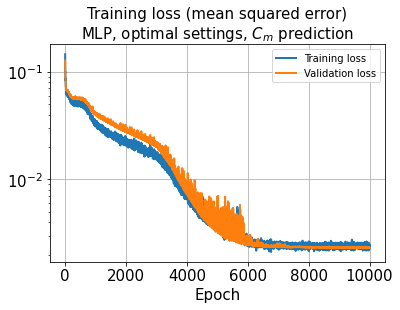

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

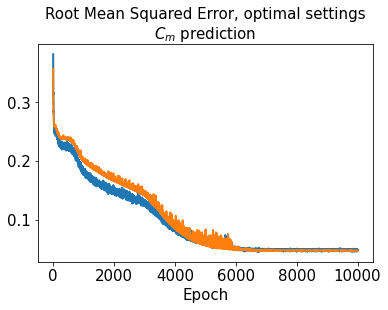

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

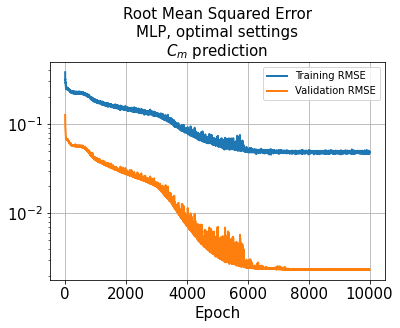

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [170]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 0.0024 - rmse: 0.0488


In [171]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 0.0022 - rmse: 0.0457


In [172]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.0024 - rmse: 0.0489


In [173]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [174]:
decoded_train_

array([[0.12532972],
       [0.2410574 ],
       [0.27558622],
       ...,
       [0.30890676],
       [0.26279628],
       [0.04804   ]], dtype=float32)

In [175]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [176]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [177]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

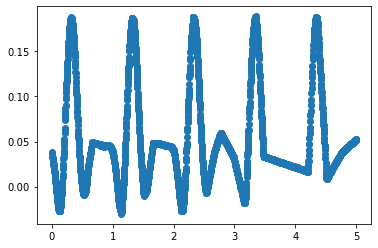

In [211]:
plt.scatter(x_train, decoded_train)

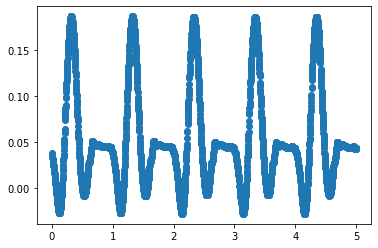

In [213]:
plt.scatter(x_train, cm_train)

In [212]:
l2_error(y_train, decoded_train)

0.13793971415099396

In [178]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [179]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [180]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [181]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState1CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [182]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [183]:
os.chdir(storage_dir)

In [184]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [185]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.1366051532115241
5.45361375138971


In [186]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.13575433215274055
5.5764664572108025


In [187]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.15046460276311693
6.119215065010862


In [188]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [189]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [190]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [191]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [192]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [193]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [194]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

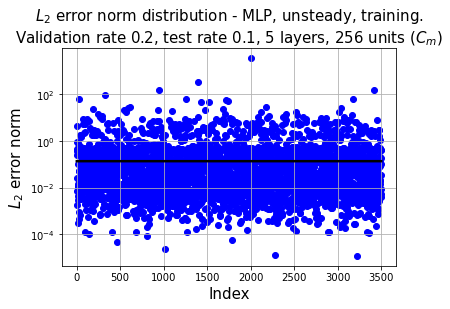

In [195]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

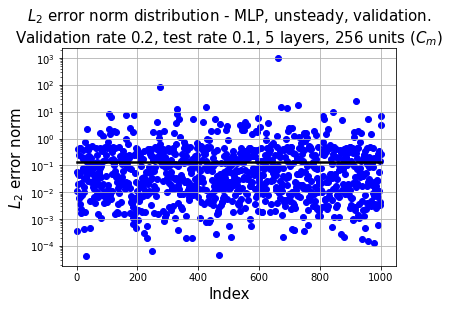

In [196]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

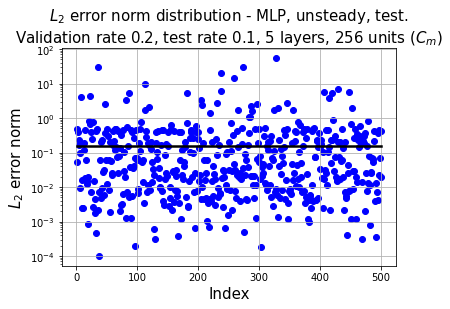

In [197]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predicted = model.predict(x)

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [198]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [199]:
predicted.shape

(5000, 1)

In [200]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [201]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [202]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [203]:
x += 10

In [204]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.1076


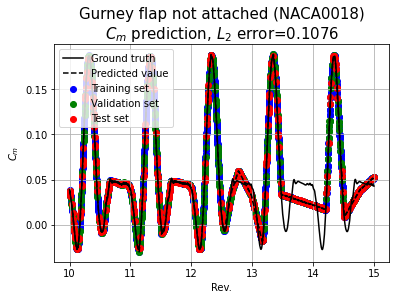

In [205]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

In [206]:
len(x_train)

3499

In [207]:
len(x_test)

500

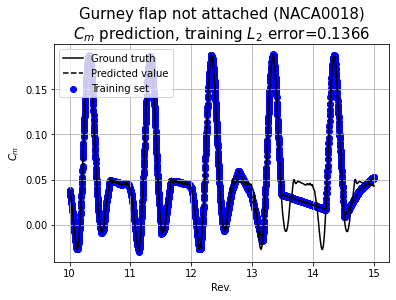

In [208]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

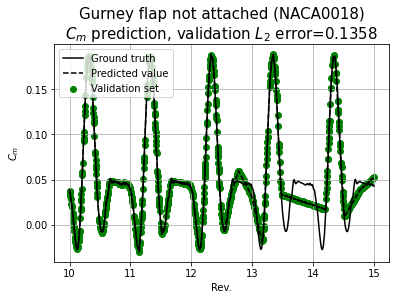

In [209]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

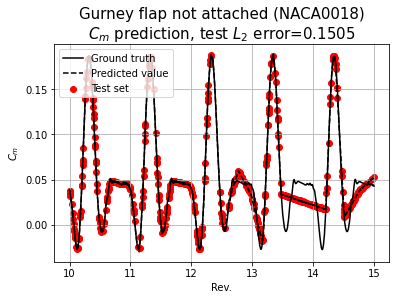

In [210]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [215]:
len(np.vstack((x_test.reshape((-1,1)), x_train.reshape((-1,1)))))

3999

In [239]:
len(x_train)

3499

In [223]:
x_test_training = np.vstack((x_test.reshape((-1,1)), x_train.reshape((-1,1))))+10
cm_test_training = np.vstack((cm_test.reshape((-1,1)), cm_train.reshape((-1,1))))
x_cm_testTraining = np.hstack((x_test_training, cm_test_training))

In [226]:
x_validation = x_val.reshape((-1,1))+10
cm_validation = cm_val.reshape((-1,1))
x_cm_validation = np.hstack((x_validation, cm_validation))

In [225]:
dfTestTrain = pd.DataFrame(x_cm_testTraining)

In [227]:
dfValidation = pd.DataFrame(x_cm_validation)

In [221]:
min(x_validation)

array([10.])

In [234]:
os.chdir(main_directory)

TypeError: 'str' object is not callable

In [237]:
os.getcwd()

'D:\\VAWT_data\\flap_unsteady\\result\\20221226_noFlapMLP_optimalSettings\\test0.1_val0.2_5layers_256units_randomState1CmPrediction'

In [240]:

dfTestTrain.to_csv('x_cm_testAndTraining_comma.txt', index=False)
dfValidation.to_csv('x_cm_validation_comma.txt',index=False)